# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 20})

# Plotting functions

In [2]:
def plot_coordinates(coordinates):
    x_coordinates = [i.x for i in coordinates]
    y_coordinates = [i.y for i in coordinates]
    
    plt.scatter(x_coordinates, y_coordinates)
    plt.xlabel('x')
    plt.ylabel('y')

    id_coordinates = [i.id for i in coordinates]
    for i, txt in enumerate(id_coordinates):
        plt.annotate(txt, (x_coordinates[i], y_coordinates[i]))

In [124]:
def plot_path(coordinates, path):
    path_coordinates = [get_coordinate(coordinates, i) for i in path]
    x_coordinates = [i.x for i in path_coordinates]
    y_coordinates = [i.y for i in path_coordinates]

    x_coordinates.append(path_coordinates[0].x)
    y_coordinates.append(path_coordinates[0].y)

    plt.plot(x_coordinates, y_coordinates, '-o')
    plt.xlabel('x')
    plt.ylabel('y')

    id_coordinates = [i.id for i in path_coordinates]
    for i, txt in enumerate(id_coordinates):
        plt.annotate(txt, (x_coordinates[i], y_coordinates[i]))

In [144]:
def plot_path_overlay(coordinates, path, opt_path):
    opt_path_coordinates = [get_coordinate(coordinates, i) for i in opt_path]
    opt_x_coordinates = [i.x for i in opt_path_coordinates]
    opt_y_coordinates = [i.y for i in opt_path_coordinates]

    opt_x_coordinates.append(opt_path_coordinates[0].x)
    opt_y_coordinates.append(opt_path_coordinates[0].y)

    plt.plot(opt_x_coordinates, opt_y_coordinates, '-o', color='orange', linewidth=10, label='Optimal')
    
    path_coordinates = [get_coordinate(coordinates, i) for i in path]
    x_coordinates = [i.x for i in path_coordinates]
    y_coordinates = [i.y for i in path_coordinates]

    x_coordinates.append(path_coordinates[0].x)
    y_coordinates.append(path_coordinates[0].y)

    plt.plot(x_coordinates, y_coordinates, '-o', color='blue', linewidth=3, label='Geo')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    id_coordinates = [i.id for i in path_coordinates]
    for i, txt in enumerate(id_coordinates):
        plt.annotate(txt, (x_coordinates[i], y_coordinates[i]))

In [73]:
def plot_coolings(average_cost_geo=None, ci_geo=None, average_cost_linear=None, ci_linear=None, average_cost_exponential=None, ci_exponential=None, average_cost_lundy=None, ci_lundy=None):
    if average_cost_geo:
        plt.errorbar(range(len(average_cost_geo)), average_cost_geo, yerr=ci_geo, c='black', ecolor='red', linestyle='dotted', label='Geo')
    if average_cost_linear:
        plt.errorbar(range(len(average_cost_linear)), average_cost_linear, yerr=ci_linear, c='black', ecolor='orange', label='Linear')
    if average_cost_exponential:
        plt.errorbar(range(len(average_cost_exponential)), average_cost_exponential, yerr=ci_exponential, c='black', ecolor='gray', linestyle='dashed', label='Exponential')
    if average_cost_lundy:
        plt.errorbar(range(len(average_cost_lundy)), average_cost_lundy, yerr=ci_lundy, c='black', ecolor='yellow', label='Lundy')

    plt.xlabel('number of iterations')
    plt.ylabel('mean route length')
    plt.legend()

# Datastructures + helperfunctions

In [5]:
class Coordinate:
    def __init__(self,id, x_init,y_init):
        self.id = id
        self.x = x_init
        self.y = y_init

In [6]:
def get_distance(coord_1,coord_2):
    return np.sqrt((coord_1.x - coord_2.x) ** 2 + (coord_1.y - coord_2.y) ** 2)

In [7]:
def get_coordinate(list_of_coords, id):
    for coord in list_of_coords:
        if coord.id == id:
            return coord

In [8]:
def get_total_cost(coordinates, solution_array):
    solution_coords = [get_coordinate(coordinates, i) for i in solution_array]
    cost = 0
    for i in range(len(solution_coords)-1):
        cost += get_distance(solution_coords[i],solution_coords[i+1])

    cost += get_distance(solution_coords[0],solution_coords[-1])

    return cost

In [9]:
def generate_initial_sol(coordinates, seed=None):
    initial_solution = list(range(1, len(coordinates)+1))

    if seed:
        np.random.seed(seed)
    np.random.shuffle(initial_solution)
    
    return initial_solution

# Simulated annealing

In [10]:
def generate_candidate_2opt(current_route):
    #length, how big?
    l = np.random.randint(2, len(current_route) - 1)
    #index, do we do this random or is there a strategy?
    index = np.random.randint(0, len(current_route) - l)

    # random_ints = np.random.choice(np.arange(0, len(current_route)), replace=False, size=(2, 1))
    # index = np.min(random_ints)
    # l = np.max(random_ints)

    candidate = current_route[:]
    candidate[index : (index + l)] = reversed(candidate[index : (index + l)])

    return candidate

In [11]:
def generate_candidate_swap(current_route):
    candidate = current_route[:]
    
    index1 = np.random.randint(0, len(candidate))
    index2 = np.random.randint(0, len(candidate))

    coordinate1 = candidate[index1]
    coordinate2 = candidate[index2]

    candidate[index1] = coordinate2
    candidate[index2] = coordinate1

    return candidate

In [12]:
def generate_candidate_move(current_route):
    candidate = current_route[:]
    
    index = np.random.randint(0, len(candidate))
    index_move = np.random.randint(0, len(candidate))

    coordinate = candidate[index]

    candidate.remove(coordinate)
    candidate.insert(index_move, coordinate)

    return candidate

In [13]:
def accept_candidate(old_cost, new_cost, T):
    a = min(np.exp(-(new_cost - old_cost) / T), 1)
    
    u = np.random.random_sample()
    
    if u <= a:
        return True
        
    return False

In [14]:
def sim_anneal(coordinates, initial_solution, T0=100, alpha=0.9, mc_length=100, cooling_schedule='geo'):
    chosen_routes = []
    costs = []

    chosen_routes.append(initial_solution.copy())
    initial_cost = get_total_cost(coordinates, initial_solution)
    costs.append(initial_cost)

    iterations_of_change = []
    T = T0
    temperatures = [T]
    decrease_rate = alpha

    stopping_criterion = 1e-12
    i=0
    
    while T > stopping_criterion:
        # print(i)
        
        # Generate a new candidate using 2opt, swap or move
        for j in range(mc_length):
            candidate = generate_candidate_2opt(chosen_routes[-1])
            # candidate = generate_candidate_swap(chosen_routes[i])
            # candidate = generate_candidate_move(chosen_routes[i])
            new_cost = get_total_cost(coordinates, candidate)

            if(accept_candidate(costs[-1], new_cost, T)):
                iterations_of_change.append((T,j))
                chosen_routes.append(candidate)
                costs.append(new_cost)
            else:
                chosen_routes.append(chosen_routes[-1])
                costs.append(costs[-1])

        #Decrease T (check for different strategies)
        #T = T - ( T * i / mc_length)
        #T = T * ((mc_length-i) / mc_length)
        if cooling_schedule == 'geo':
            T = T * decrease_rate
        elif cooling_schedule == 'linear':
              T = T - ( T0 * 1 /300)
        elif cooling_schedule == 'exponential':
            if i >= 300:
                break
            T = T0/(1+np.exp((i-100)/(6)))
            i+=1
        elif cooling_schedule == 'lundy':
            if i>=300:
                break
            T = T/(1 + 1/T0*T)
            i +=1
        temperatures.append(T)
        
    return chosen_routes, costs, iterations_of_change, temperatures

# Testing our algorithm on EIL51 data with random parameters

## Loading coordinates

In [15]:
df = pd.read_csv('./eil51.tsp.txt', header=None, skiprows=6, skipfooter=1, sep=' ', engine='python', index_col=0)
# df.set_index(df[0])
print(df)

     1   2
0         
1   37  52
2   49  49
3   52  64
4   20  26
5   40  30
6   21  47
7   17  63
8   31  62
9   52  33
10  51  21
11  42  41
12  31  32
13   5  25
14  12  42
15  36  16
16  52  41
17  27  23
18  17  33
19  13  13
20  57  58
21  62  42
22  42  57
23  16  57
24   8  52
25   7  38
26  27  68
27  30  48
28  43  67
29  58  48
30  58  27
31  37  69
32  38  46
33  46  10
34  61  33
35  62  63
36  63  69
37  32  22
38  45  35
39  59  15
40   5   6
41  10  17
42  21  10
43   5  64
44  30  15
45  39  10
46  32  39
47  25  32
48  25  55
49  48  28
50  56  37
51  30  40


In [16]:
coordinates = []
for index, row in df.iterrows():
    coordinates.append(Coordinate(index,row[1],row[2]))

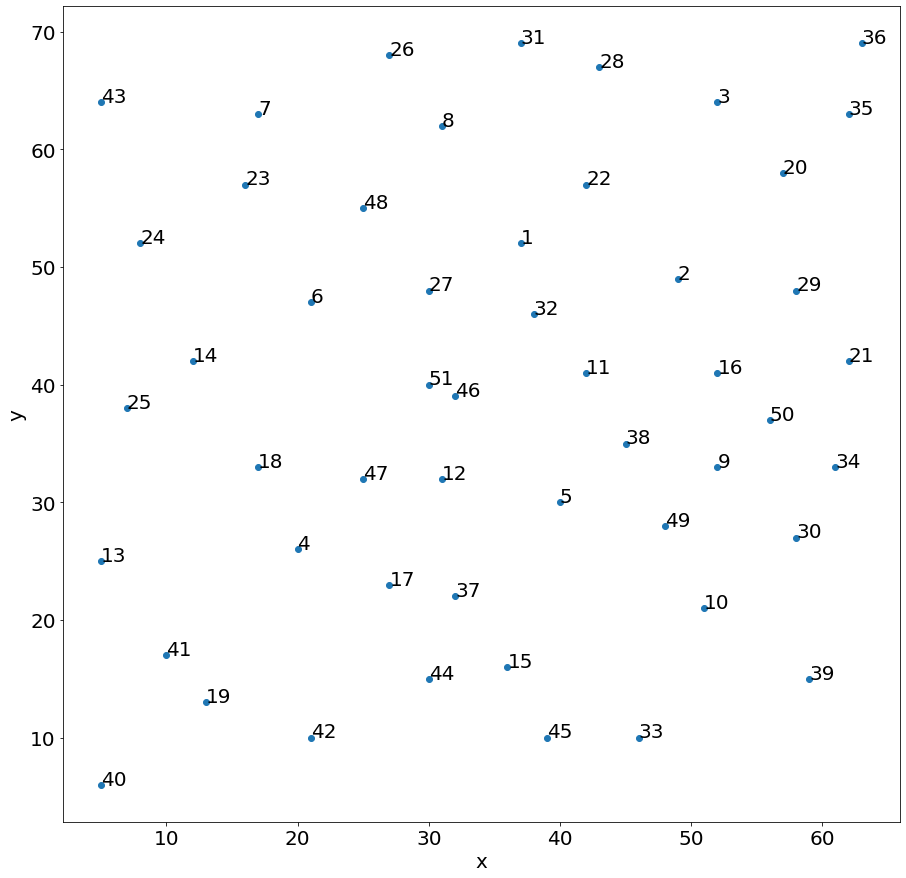

In [17]:
plot_coordinates(coordinates)

In [18]:
solution = [i+1 for i in range(len(df)-1)]
print(solution)
get_total_cost(coordinates, solution)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


1297.6108326721117

## Simulated annealing test

final route:
[4, 42, 40, 19, 41, 17, 44, 37, 45, 33, 15, 12, 47, 38, 11, 5, 49, 10, 39, 30, 9, 34, 50, 16, 2, 21, 29, 20, 35, 36, 3, 28, 26, 31, 8, 22, 1, 32, 51, 46, 27, 48, 7, 43, 24, 23, 6, 14, 25, 13, 18]
final distance 517.0017792056387
number of new solutions accepted: 20963


Text(0, 0.5, 'mean route length')

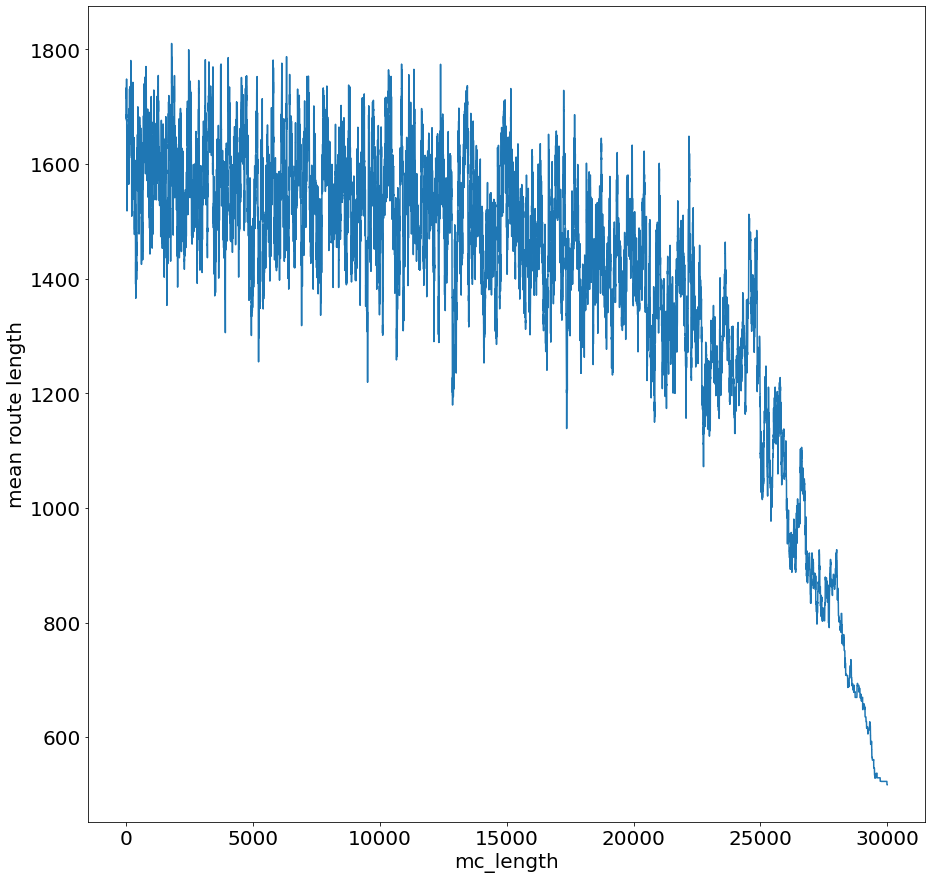

In [19]:
initial_solution = generate_initial_sol(coordinates)
routes, costs, iters, temperatures = sim_anneal(coordinates, initial_solution, cooling_schedule='linear')
print(f"final route:\n{routes[-1]}")
print(f"final distance {costs[-1]}")
print(f"number of new solutions accepted: {len(iters)}")
#print(f"done at iterations: {iters}")
plt.plot(costs)
plt.xlabel('mc_length')
plt.ylabel('mean route length')

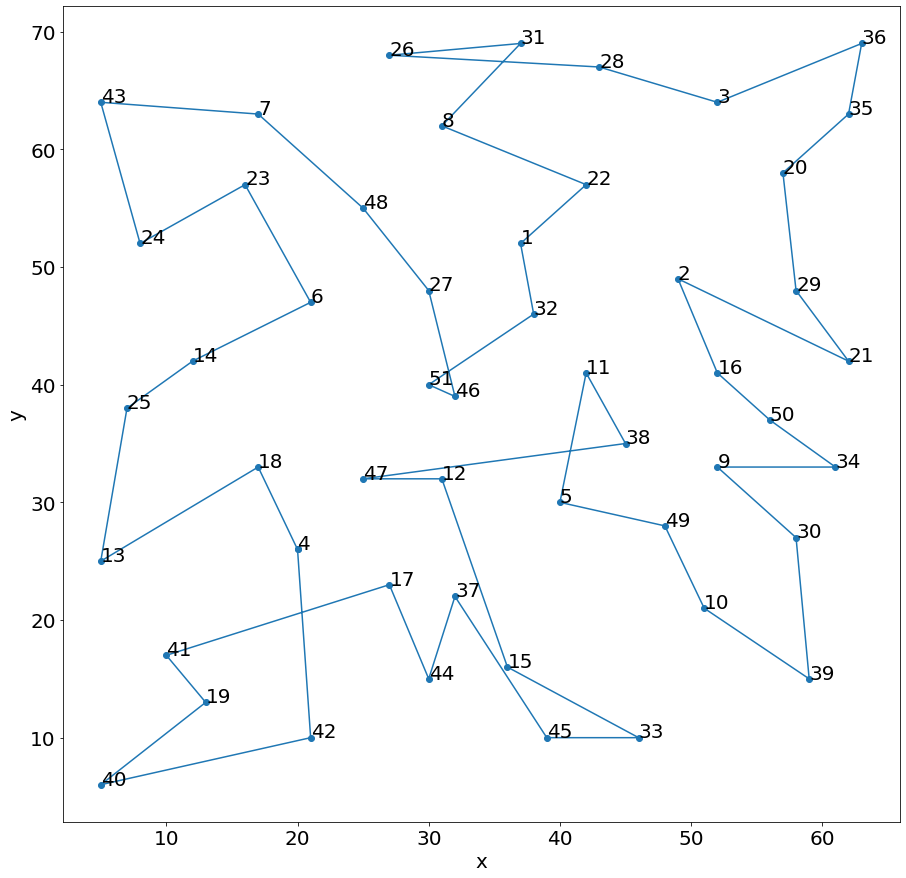

In [20]:
plot_path(coordinates, routes[-1])

In [21]:
# plt.plot(temperatures)

## Compare to given optimal solution

In [22]:
opt_df = pd.read_csv('./eil51.opt.tour.txt', header=None, skiprows=5, skipfooter=1, sep=' ', engine='python')

In [23]:
opt_sol = opt_df.iloc[:,0].values[:-1]
#append 1 on end iinstead of -1
#opt_sol[-1] = 1
print(opt_sol)

[ 1 22  8 26 31 28  3 36 35 20  2 29 21 16 50 34 30  9 49 10 39 33 45 15
 44 42 40 19 41 13 25 14 24 43  7 23 48  6 27 51 46 12 47 18  4 17 37  5
 38 11 32]


In [24]:
get_total_cost(coordinates, opt_sol)

429.98331198338406

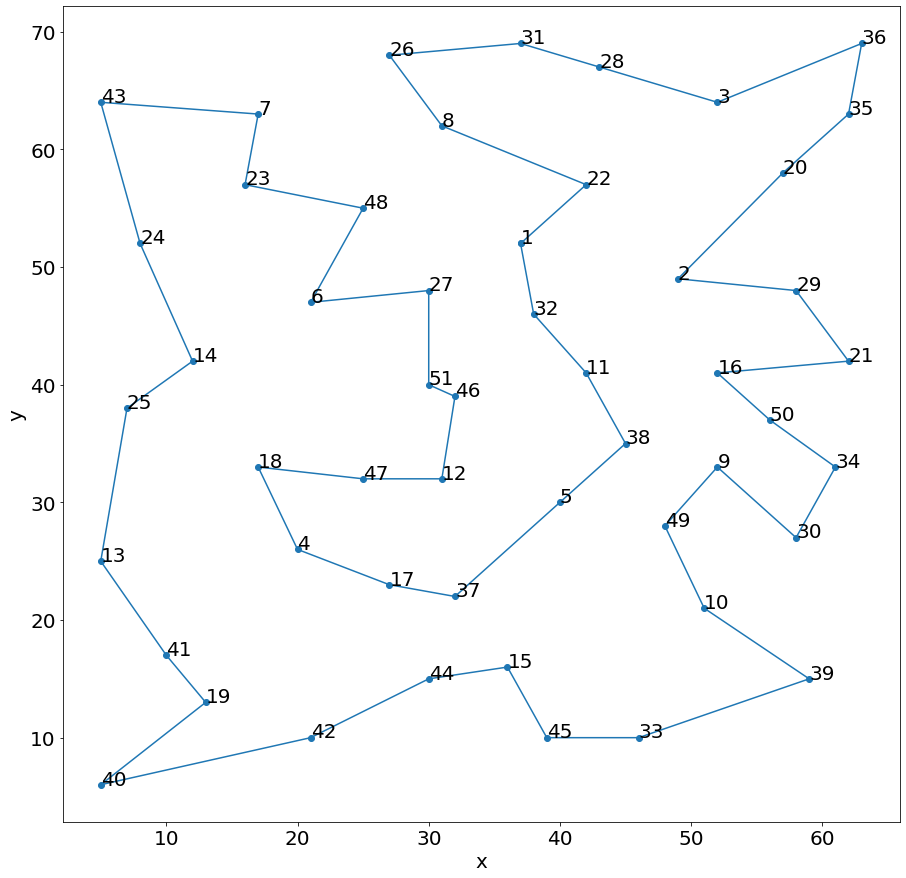

In [25]:
plot_path(coordinates, opt_sol)

# Finding optimal cooling strategy and parameters using A280 data

## Loading coordinates

In [26]:
df_a280 = pd.read_csv("./a280.tsp.txt",skiprows=5,skipfooter=1)

<ipython-input-26-bdd810d8f184>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_a280 = pd.read_csv("./a280.tsp.txt",skiprows=5,skipfooter=1)


In [27]:
indexes = []
xs = []
ys = []
for index, row in df_a280.iterrows():
    indexes.append(int(df_a280['NODE_COORD_SECTION'].str.split()[index][0]))
    xs.append(int(df_a280['NODE_COORD_SECTION'].str.split()[index][1]))
    ys.append(int(df_a280['NODE_COORD_SECTION'].str.split()[index][2]))

data_df_a280 = np.array([indexes,xs,ys]).T
df_a280 = pd.DataFrame(data_df_a280,columns=['id','x','y'])

In [28]:
df_a280.set_index('id')

x    y
id           
1    288  149
2    288  129
3    270  133
4    256  141
5    256  157
..   ...  ...
276  236  145
277  246  141
278  252  125
279  260  129
280  280  133

[280 rows x 2 columns]

In [29]:
coordinates_a280 = []
for index, row in df_a280.iterrows():
    coordinates_a280.append(Coordinate(index+1,row[1],row[2]))

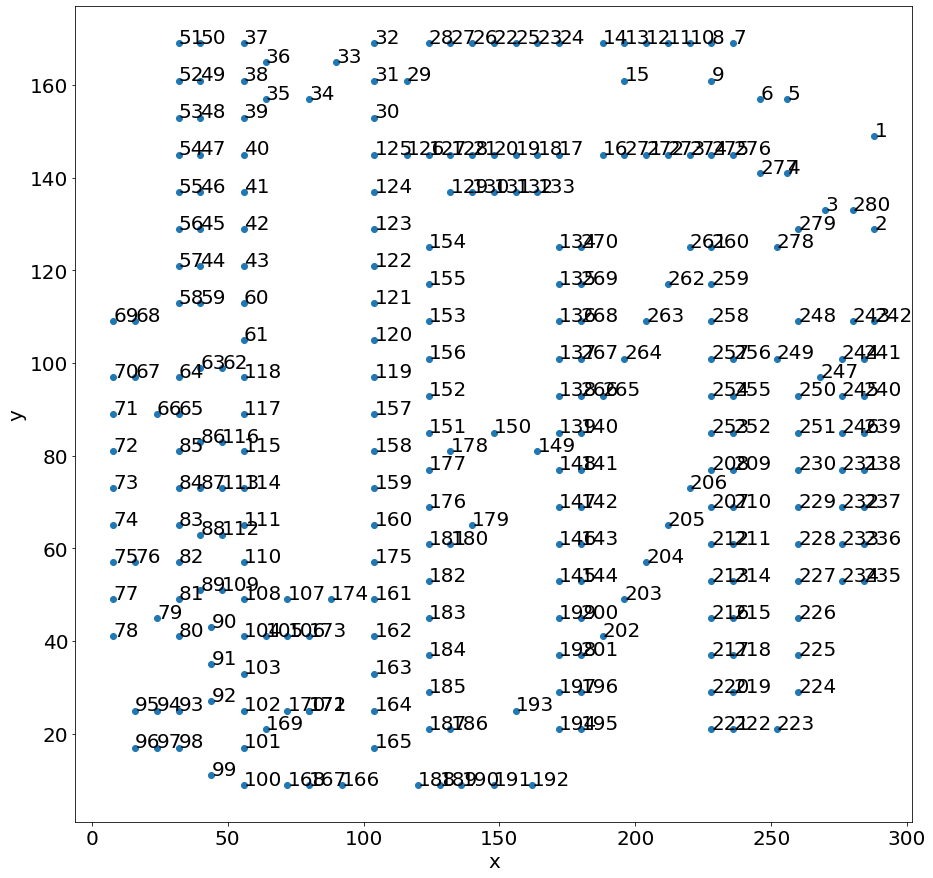

In [30]:
plot_coordinates(coordinates_a280)

## Testing varying cooling schedules

In [31]:
def geo_cooling(T0, decrease_rate, stop):
    y = [T0]
    T = T0
    i= 0
    while T > stop:
        T = T * decrease_rate
        y.append(T)
        i+=1

    return y,i

In [32]:
def linear_cooling(T0, stop):
    y = [T0]
    T = T0

    while T > stop:
        T = T - ( T0 * 1 /300)
        y.append(T)

    return y

In [33]:
def exponential_cooling(T0,stop):
    y = [T0]
    T = T0
    i = 0
    while T>stop:
        if i > 500:
            return y
        T = T0/(1+np.exp((i-100)/(6)))
        y.append(T)
        i+=1

    return y

In [34]:
def lundy_cooling(T0, stop):
    y = [T0]
    T = T0
    i = 0
    while T > stop:
        if i>=300:
            print(T)
            return y
        # T = T0/(1 + np.log(1 + i/(mc_length / T0)))
        T = T/(1 + 1/(T0)*T)
        y.append(T)
        i +=1

    return y

307
301
296
0.33222591362126297
301


Text(0, 0.5, 'T')

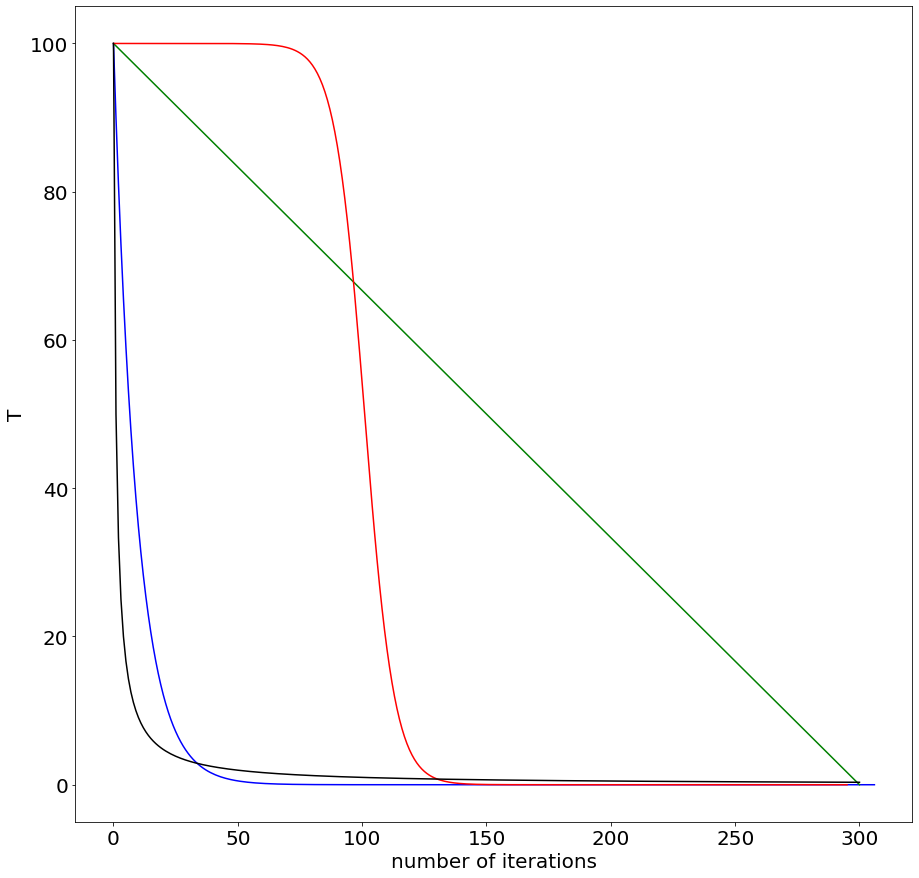

In [35]:
T0 = 100

geo_cooling_y, i = geo_cooling(T0, 0.9, 1e-12)
print(len(geo_cooling_y))
#print(geo_cooling_y)
linear_y = linear_cooling(T0, 1e-12)
print(len(linear_y))
exponential_y = exponential_cooling(T0, 1e-12)
print(len(exponential_y))
lundy_y = lundy_cooling(T0, 1e-12)
print(len(lundy_y))
# print(lundy_y[-1] -lundy_y[-2])

plt.plot(geo_cooling_y, c='blue', label='Geo')
plt.plot(linear_y, c='green', label='Linear')
plt.plot(exponential_y, c='red', label='Exponential')
plt.plot(lundy_y, c='black', label='Lundy')
plt.xlabel('number of iterations')
plt.ylabel('T')

In [36]:
# cooling_schedules = ['geo', 'linear', 'exponential', 'lundy']
mc_length = 100
T0 = 100
n_runs = 25

routes_geo = []
costs_geo = []

routes_linear = []
costs_linear = []

routes_exponential = []
costs_exponential = []

routes_lundy = []
costs_lundy = []

for i in range(n_runs):
    print(i)

    initial_solution = generate_initial_sol(coordinates_a280)
    
    routes, costs, iters, temperatures = sim_anneal(coordinates_a280, initial_solution, T0=T0, mc_length=mc_length, cooling_schedule='geo')
    routes_geo.append(routes)
    costs_geo.append(costs)

    print('geo done')

    routes, costs, iters, temperatures = sim_anneal(coordinates_a280, initial_solution, T0=T0, mc_length=mc_length, cooling_schedule='linear')
    routes_linear.append(routes)
    costs_linear.append(costs)

    print('linear done')

    routes, costs, iters, temperatures = sim_anneal(coordinates_a280, initial_solution, T0=T0, mc_length=mc_length, cooling_schedule='exponential')
    routes_exponential.append(routes)
    costs_exponential.append(costs)

    print('exponential done')

    routes, costs, iters, temperatures = sim_anneal(coordinates_a280, initial_solution, T0=T0, mc_length=mc_length, cooling_schedule='lundy')
    routes_lundy.append(routes)
    costs_lundy.append(costs)

    print('lundy done')

0


<ipython-input-13-59b058093738>:2: RuntimeWarning: overflow encountered in exp
  a = min(np.exp(-(new_cost - old_cost) / T), 1)


geo done
linear done
exponential done
lundy done
1
geo done
linear done
exponential done
lundy done
2
geo done
linear done
exponential done
lundy done
3
geo done
linear done
exponential done
lundy done
4
geo done
linear done
exponential done
lundy done
5
geo done
linear done
exponential done
lundy done
6
geo done
linear done
exponential done
lundy done
7
geo done
linear done
exponential done
lundy done
8
geo done
linear done
exponential done
lundy done
9
geo done
linear done
exponential done
lundy done
10
geo done
linear done
exponential done
lundy done
11
geo done
linear done
exponential done
lundy done
12
geo done
linear done
exponential done
lundy done
13
geo done
linear done
exponential done
lundy done
14
geo done
linear done
exponential done
lundy done
15
geo done
linear done
exponential done
lundy done
16
geo done
linear done
exponential done
lundy done
17
geo done
linear done
exponential done
lundy done
18
geo done
linear done
exponential done
lundy done
19
geo done
linear done


In [37]:
#Calculate all the averages and ci's for all mc steps
average_cost_per_mc_step_geo = []
ci_per_mc_step_geo = []

for i in range(len(routes_geo[0])):
    costs_temp = []
    for k in costs_geo:
        costs_temp.append(k[i])
    average_cost_per_mc_step_geo.append(np.mean(costs_temp))
    ci_per_mc_step_geo.append(1.96*np.std(costs_temp)/np.sqrt(len(costs_temp))) 

average_cost_per_mc_step_linear = []
ci_per_mc_step_linear = []

for i in range(len(routes_linear[0])):
    costs_temp = []
    for k in costs_linear:
        costs_temp.append(k[i])
    average_cost_per_mc_step_linear.append(np.mean(costs_temp))
    ci_per_mc_step_linear.append(1.96*np.std(costs_temp)/np.sqrt(len(costs_temp))) 

average_cost_per_mc_step_exponential = []
ci_per_mc_step_exponential = []

for i in range(len(routes_exponential[0])):
    costs_temp = []
    for k in costs_exponential:
        costs_temp.append(k[i])
    average_cost_per_mc_step_exponential.append(np.mean(costs_temp))
    ci_per_mc_step_exponential.append(1.96*np.std(costs_temp)/np.sqrt(len(costs_temp))) 

average_cost_per_mc_step_lundy = []
ci_per_mc_step_lundy = []

for i in range(len(routes_lundy[0])):
    costs_temp = []
    for k in costs_lundy:
        costs_temp.append(k[i])
    average_cost_per_mc_step_lundy.append(np.mean(costs_temp))
    ci_per_mc_step_lundy.append(1.96*np.std(costs_temp)/np.sqrt(len(costs_temp))) 

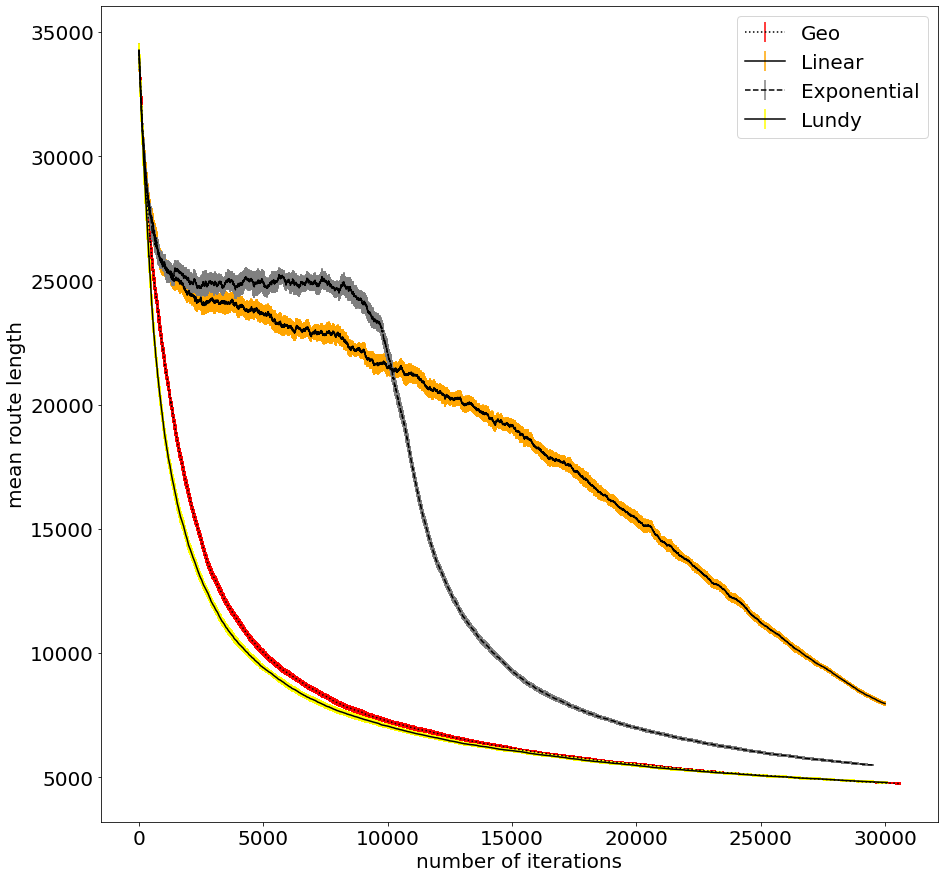

In [74]:
plot_coolings(average_cost_geo=average_cost_per_mc_step_geo, ci_geo=ci_per_mc_step_geo, average_cost_linear=average_cost_per_mc_step_linear, ci_linear=ci_per_mc_step_linear, average_cost_exponential=average_cost_per_mc_step_exponential, ci_exponential=ci_per_mc_step_exponential, average_cost_lundy=average_cost_per_mc_step_lundy, ci_lundy=ci_per_mc_step_lundy)

In [39]:
print(average_cost_per_mc_step_geo[-1])
print(average_cost_per_mc_step_linear[-1])
print(average_cost_per_mc_step_exponential[-1])
print(average_cost_per_mc_step_lundy[-1])

4744.196659811024
7965.635131961971
5495.983829184452
4787.241141482132


In [69]:
print(ci_per_mc_step_geo[-1])
print(ci_per_mc_step_linear[-1])
print(ci_per_mc_step_exponential[-1])
print(ci_per_mc_step_lundy[-1])

44.682785811288134
84.62557661084519
48.048437588470996
56.355293311322136


In [70]:
stat, p = stats.ttest_ind(average_cost_per_mc_step_geo, average_cost_per_mc_step_linear, equal_var=False)
print("Welch t-test between geo and linear cooling gives test statistic of {} with p-value {}".format(stat, p))

stat, p = stats.ttest_ind(average_cost_per_mc_step_geo, average_cost_per_mc_step_exponential, equal_var=False)
print("Welch t-test between geo and exponential cooling gives test statistic of {} with p-value {}".format(stat, p))

stat, p = stats.ttest_ind(average_cost_per_mc_step_geo, average_cost_per_mc_step_lundy, equal_var=False)
print("Welch t-test between geo and lundy cooling gives test statistic of {} with p-value {}".format(stat, p))

Welch t-test between geo and linear cooling gives test statistic of -244.22945844153912 with p-value 0.0
Welch t-test between geo and exponential cooling gives test statistic of -111.54842327088963 with p-value 0.0
Welch t-test between geo and lundy cooling gives test statistic of 8.280087026908122 with p-value 1.2557876646334725e-16


We find that cooling strategy 'Geo' performs the best.

## Testing varying T0

In [41]:
Ts = [10, 50, 100, 500, 1000, 5000, 10000]

mc_length = 100
n_runs = 25

all_average_costs_t0 = []
all_cis_t0 = []

for T0 in Ts:
    print(T0)

    routes_t0 = []
    costs_t0 = []

    for i in range(n_runs):
        print(i)

        initial_solution = generate_initial_sol(coordinates_a280, seed=i)
        
        routes, costs, iters, temperatures = sim_anneal(coordinates_a280, initial_solution, mc_length=mc_length, T0=T0, cooling_schedule='geo')
        routes_t0.append(routes)
        costs_t0.append(costs)

    average_cost_per_mc_step_t0 = []
    ci_per_mc_step_t0 = []

    for i in range(len(routes_t0[0])):
        costs_temp = []
        for k in costs_t0:
            costs_temp.append(k[i])
        average_cost_per_mc_step_t0.append(np.mean(costs_temp))
        ci_per_mc_step_t0.append(1.96*np.std(costs_temp)/np.sqrt(len(costs_temp))) 

    all_average_costs_t0.append(average_cost_per_mc_step_t0)
    all_cis_t0.append(ci_per_mc_step_t0)

10
0


<ipython-input-13-59b058093738>:2: RuntimeWarning: overflow encountered in exp
  a = min(np.exp(-(new_cost - old_cost) / T), 1)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
50
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
500
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
1000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
5000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
10000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


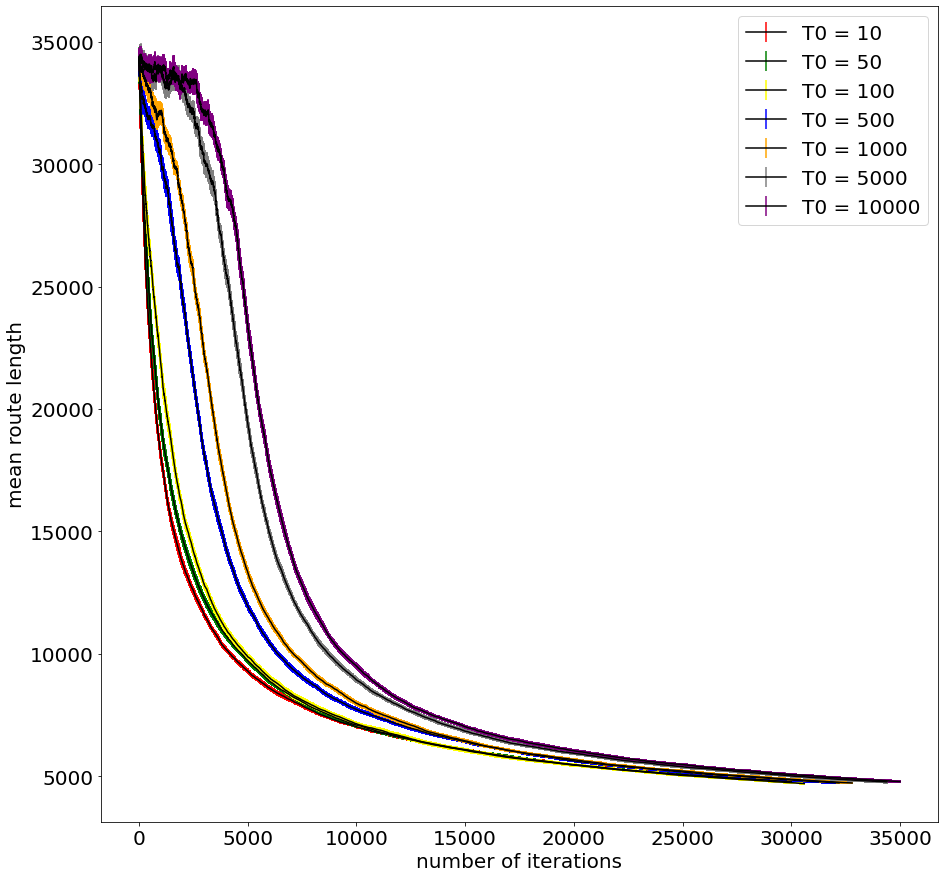

In [71]:
colors = ['red', 'green', 'yellow', 'blue', 'orange', 'gray', 'purple']

for index, T0 in enumerate(Ts):
    plt.errorbar(range(len(all_average_costs_t0[index])), all_average_costs_t0[index], yerr=all_cis_t0[index], c='black', ecolor=colors[index], label='T0 = {}'.format(T0))
    plt.xlabel('number of iterations')
    plt.ylabel('mean route length')
    plt.legend()

In [43]:
for t0_run in all_average_costs_t0:
    print(t0_run[-1])

4854.937692527284
4778.55211104274
4701.770955150472
4730.733596503508
4726.274014853244
4769.867505828602
4784.7833268859595


In [44]:
for t0_run in all_cis_t0:
    print(t0_run[-1])

45.439310274272835
47.93742232197696
46.83302053970998
65.12521217642902
55.893353798932196
68.34938735352222
64.25400569361909


In [45]:
for index, T0 in enumerate(Ts):
    if index + 1 == len(Ts):
        break
    stat, p = stats.ttest_ind(all_average_costs_t0[index], all_average_costs_t0[index+1], equal_var=False)
    print("Welch t-test between T0 = {} and T0 = {} gives test statistic of {} with p-value {}".format(Ts[index], Ts[index + 1], stat, p))

Welch t-test between T0 = 10 and T0 = 50 gives test statistic of -1.0519417911082727 with p-value 0.2928306021395401
Welch t-test between T0 = 50 and T0 = 100 gives test statistic of -3.2734518436351836 with p-value 0.0010630225266182853
Welch t-test between T0 = 100 and T0 = 500 gives test statistic of -22.919869918523066 with p-value 9.500880159647037e-116
Welch t-test between T0 = 500 and T0 = 1000 gives test statistic of -8.446134520887894 with p-value 3.072726264959276e-17
Welch t-test between T0 = 1000 and T0 = 5000 gives test statistic of -18.41557839992726 with p-value 1.5242685969202136e-75
Welch t-test between T0 = 5000 and T0 = 10000 gives test statistic of -6.925672054878967 with p-value 4.376754126864113e-12


In [107]:
stat, p = stats.ttest_ind(all_average_costs_t0[2], all_average_costs_t0[0], equal_var=False)
print("Welch t-test between T0 = 100 and T0 = 10 gives test statistic of {} with p-value {}".format(stat, p))

stat, p = stats.ttest_ind(all_average_costs_t0[2], all_average_costs_t0[1], equal_var=False)
print("Welch t-test between T0 = 100 and T0 = 50 gives test statistic of {} with p-value {}".format(stat, p))

stat, p = stats.ttest_ind(all_average_costs_t0[2], all_average_costs_t0[3], equal_var=False)
print("Welch t-test between T0 = 100 and T0 = 500 gives test statistic of {} with p-value {}".format(stat, p))

stat, p = stats.ttest_ind(all_average_costs_t0[2], all_average_costs_t0[4], equal_var=False)
print("Welch t-test between T0 = 100 and T0 = 1000 gives test statistic of {} with p-value {}".format(stat, p))

stat, p = stats.ttest_ind(all_average_costs_t0[2], all_average_costs_t0[5], equal_var=False)
print("Welch t-test between T0 = 100 and T0 = 5000 gives test statistic of {} with p-value {}".format(stat, p))

Welch t-test between T0 = 100 and T0 = 10 gives test statistic of 4.334866332858105 with p-value 1.4609091704602437e-05
Welch t-test between T0 = 100 and T0 = 50 gives test statistic of 3.2734518436351836 with p-value 0.0010630225266182853
Welch t-test between T0 = 100 and T0 = 500 gives test statistic of -22.919869918523066 with p-value 9.500880159647037e-116
Welch t-test between T0 = 100 and T0 = 1000 gives test statistic of -30.87989142582019 with p-value 1.1782352928201498e-207
Welch t-test between T0 = 100 and T0 = 5000 gives test statistic of -48.59517838195844 with p-value 0.0


We find that T0 = 100 provides us with the best results.

## Varying mc_length

In [53]:
mc_lengths = [10, 100, 500, 1000]

T0 = 100
n_runs = 25

all_average_costs_mc_length = []
all_cis_mc_length = []

for mc_length in mc_lengths:
    print(mc_length)

    routes_mc_length = []
    costs_mc_length = []

    for i in range(n_runs):
        print(i)

        initial_solution = generate_initial_sol(coordinates_a280, seed=i)
        
        routes, costs, iters, temperatures = sim_anneal(coordinates_a280, initial_solution, mc_length=mc_length, T0=T0, cooling_schedule='geo')
        routes_mc_length.append(routes)
        costs_mc_length.append(costs)

    average_cost_per_mc_step_mc_length = []
    ci_per_mc_step_mc_length = []

    for i in range(len(routes_mc_length[0])):
        costs_temp = []
        for k in costs_mc_length:
            costs_temp.append(k[i])
        average_cost_per_mc_step_mc_length.append(np.mean(costs_temp))
        ci_per_mc_step_mc_length.append(1.96*np.std(costs_temp)/np.sqrt(len(costs_temp))) 

    all_average_costs_mc_length.append(average_cost_per_mc_step_mc_length)
    all_cis_mc_length.append(ci_per_mc_step_mc_length)

10
0


<ipython-input-13-59b058093738>:2: RuntimeWarning: overflow encountered in exp
  a = min(np.exp(-(new_cost - old_cost) / T), 1)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
500
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
1000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


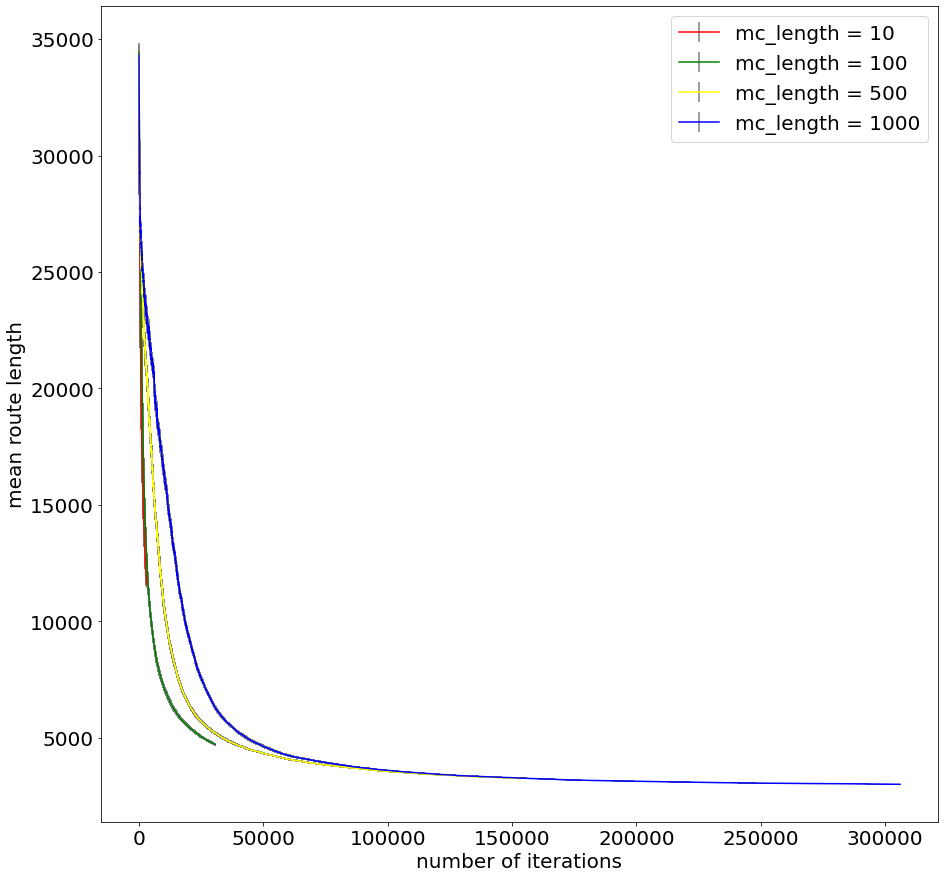

In [54]:
colors = ['red', 'green', 'yellow', 'blue', 'orange', 'purple', 'black']

for index, mc_length in enumerate(mc_lengths):
    plt.errorbar(range(len(all_average_costs_mc_length[index])), all_average_costs_mc_length[index], yerr=all_cis_mc_length[index], c=colors[index], ecolor='gray', label='mc_length = {}'.format(mc_length))
    plt.legend()
    plt.xlabel('number of iterations')
    plt.ylabel('mean route length')

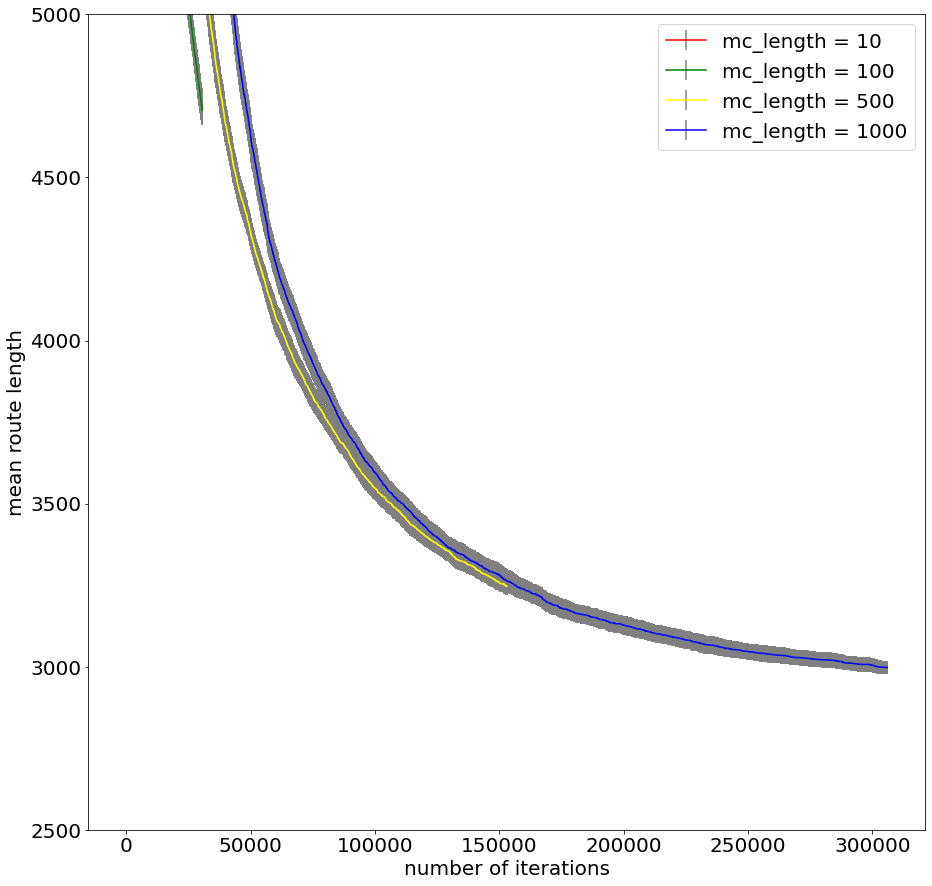

In [55]:
colors = ['red', 'green', 'yellow', 'blue', 'orange', 'purple', 'black']

for index, mc_length in enumerate(mc_lengths):
    plt.errorbar(range(len(all_average_costs_mc_length[index])), all_average_costs_mc_length[index], yerr=all_cis_mc_length[index], c=colors[index], ecolor='gray', label='mc_length = {}'.format(mc_length))
    plt.legend()
    plt.xlabel('number of iterations')
    plt.ylabel('mean route length')
    plt.ylim(2500, 5000)

In [56]:
for mc_length_run in all_average_costs_mc_length:
    print(mc_length_run[-1])

11579.734193117009
4706.4870735484055
3246.426010846129
2997.74530357169


In [57]:
for mc_length_run in all_cis_mc_length:
    print(mc_length_run[-1])

138.506192568357
45.3254368497575
26.49582588439829
20.24474809431384


We find that an mc_length of 1,000 using T0 = 100 provides us with the best results and that there is still room for improvement using a higher mc_length.

## Final simulation using 'Geo' cooling schedule, T0 = 100, and mc_length = 2,500

In [58]:
batch_routes_a280 = []
batch_costs_a280 = []
n_runs = 25

mc_length = 2500
T0 = 100

for i in range(n_runs):
    print(i)
    
    initial_solution_a280 = generate_initial_sol(df_a280)
    routes_a280, costs_a280, iters_a280, temperatures_a280 = sim_anneal(coordinates_a280, initial_solution_a280, T0=T0, mc_length=mc_length, cooling_schedule='geo')
    batch_routes_a280.append(routes_a280)
    batch_costs_a280.append(costs_a280)

0


<ipython-input-13-59b058093738>:2: RuntimeWarning: overflow encountered in exp
  a = min(np.exp(-(new_cost - old_cost) / T), 1)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [59]:
#Calculate all the averages and ci's for all mc steps
average_cost_per_mc_step_a280 = []
ci_per_mc_step_a280 = []
for i in range(len(batch_routes_a280[0])):
    costs_temp_a280 = []
    for k in batch_costs_a280:
        costs_temp_a280.append(k[i])
    average_cost_per_mc_step_a280.append(np.mean(costs_temp_a280))
    ci_per_mc_step_a280.append(1.96*np.std(costs_temp_a280)/np.sqrt(len(costs_temp_a280))) 

Text(0, 0.5, 'mean route length')

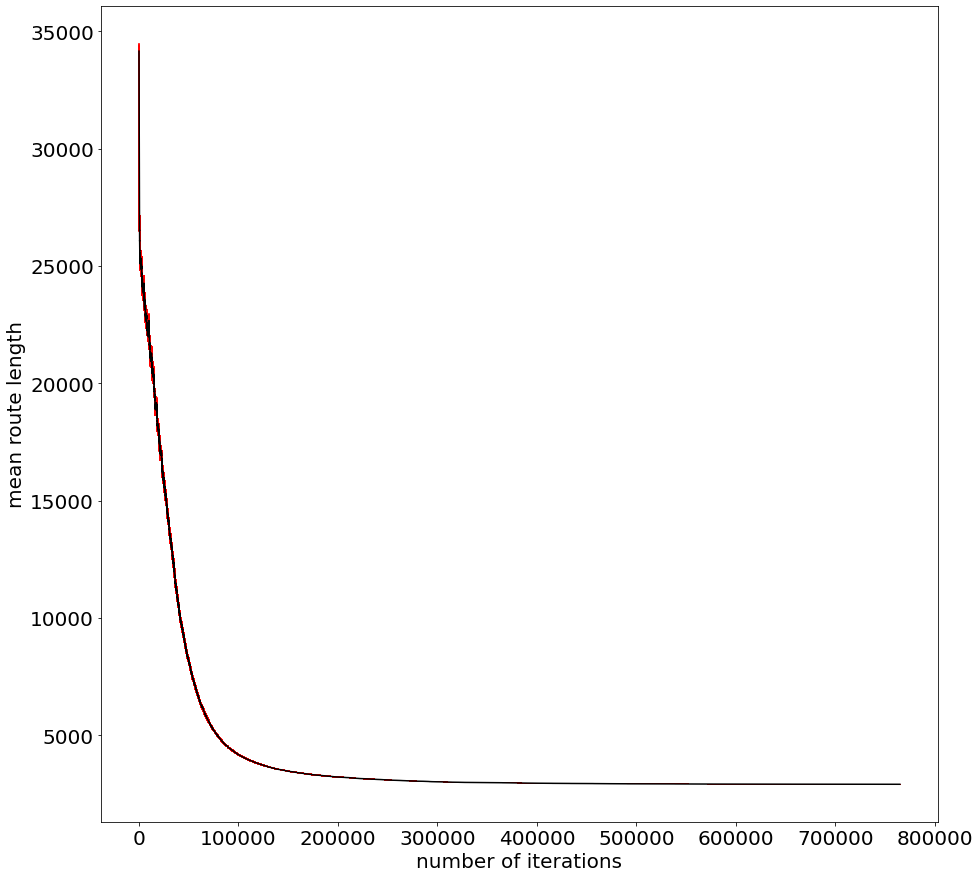

In [60]:
plt.errorbar(range(len(average_cost_per_mc_step_a280)), average_cost_per_mc_step_a280, yerr=ci_per_mc_step_a280, c='black', ecolor='red')
plt.xlabel('number of iterations')
plt.ylabel('mean route length')

In [61]:
print(average_cost_per_mc_step_a280[-1])

2912.2592863965815


In [75]:
print(ci_per_mc_step_a280[-1])

19.643874585094757


In [76]:
print(len(average_cost_per_mc_step_a280))

765001


In [63]:
print(routes_a280[-1])

[9, 11, 10, 8, 7, 6, 5, 1, 2, 280, 3, 4, 279, 278, 248, 249, 250, 251, 247, 245, 244, 243, 242, 241, 240, 239, 246, 231, 238, 237, 236, 235, 234, 233, 232, 230, 229, 228, 227, 226, 225, 224, 223, 219, 222, 221, 220, 217, 218, 215, 216, 213, 214, 211, 212, 206, 205, 204, 203, 202, 200, 201, 196, 195, 194, 192, 191, 193, 197, 198, 199, 144, 145, 146, 143, 142, 141, 140, 148, 147, 149, 139, 138, 266, 265, 267, 137, 136, 135, 134, 133, 18, 19, 20, 132, 131, 130, 129, 154, 155, 153, 156, 152, 151, 177, 178, 150, 179, 180, 176, 181, 182, 183, 161, 162, 163, 184, 185, 187, 186, 190, 189, 188, 164, 165, 166, 167, 168, 171, 172, 170, 169, 101, 100, 99, 92, 102, 103, 91, 90, 109, 89, 88, 83, 82, 76, 79, 81, 80, 94, 93, 98, 97, 96, 95, 78, 77, 75, 74, 73, 72, 71, 70, 67, 69, 68, 58, 64, 63, 59, 44, 45, 57, 56, 55, 46, 47, 54, 53, 48, 49, 52, 51, 50, 37, 38, 36, 33, 34, 35, 39, 40, 41, 42, 43, 60, 61, 62, 118, 117, 115, 116, 86, 65, 66, 85, 84, 87, 113, 114, 111, 112, 110, 108, 104, 105, 107, 106,

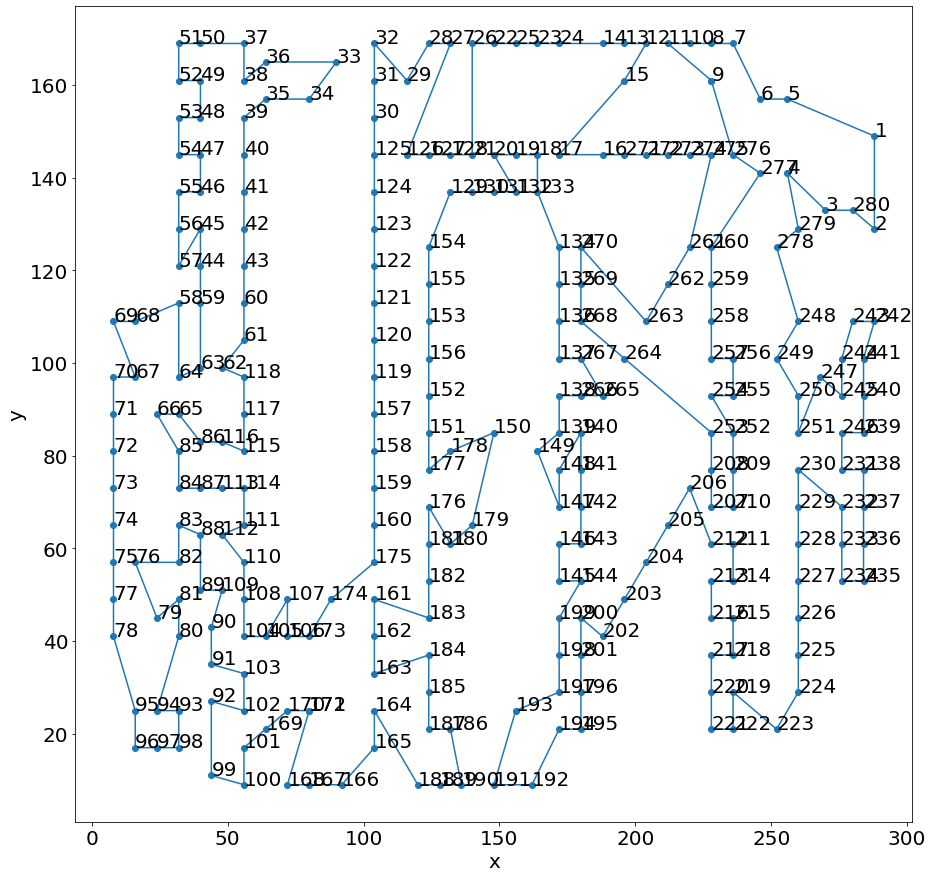

In [64]:
plot_path(coordinates_a280, routes_a280[-1])

## Compare to given optimal solution

In [65]:
opt_df_a280 = pd.read_csv('./a280.opt.tour.txt', header=None, skiprows=5, skipfooter=1, sep=' ', engine='python')

In [66]:
opt_sol_a280 = opt_df_a280.iloc[:,0].values[:-1]
#append 1 on end iinstead of -1
#opt_sol[-1] = 1
print(opt_sol_a280)

[  2 242 243 244 241 240 239 238 237 236 235 234 233 232 231 246 245 247
 250 251 230 229 228 227 226 225 224 223 222 221 220 219 218 217 216 215
 214 213 212 211 210 207 206 205 204 203 202 201 198 197 196 195 194 193
 192 191 190 189 188 187 186 185 184 183 182 181 176 180 179 150 178 177
 151 152 156 153 155 154 129 130 131  20  21 128 127 126 125 124 123 122
 121 120 119 157 158 159 160 175 161 162 163 164 165 166 167 168 169 170
 172 171 173 174 107 106 105 104 103 102 101 100  99  98  97  96  95  94
  93  92  91  90  89 109 108 110 111 112  88  87 113 114 115 117 116  86
  85  84  83  82  81  80  79  78  77  76  75  74  73  72  71  70  69  68
  67  66  65  64  58  57  56  55  54  53  52  51  50  49  48  47  46  45
  44  59  63  62 118  61  60  43  42  41  40  39  38  37  36  35  34  33
  32  31  30  29  28  27  26  22  25  23  24  14  15  13  12  11  10   9
   8   7   6   5   4 277 276 275 274 273 272 271  16  17  18  19 132 133
 134 270 269 135 136 268 267 137 138 139 149 148 14

In [105]:
opt_cost_a280 = get_total_cost(coordinates_a280, opt_sol_a280)
print(opt_cost_a280)

2557.320192657748


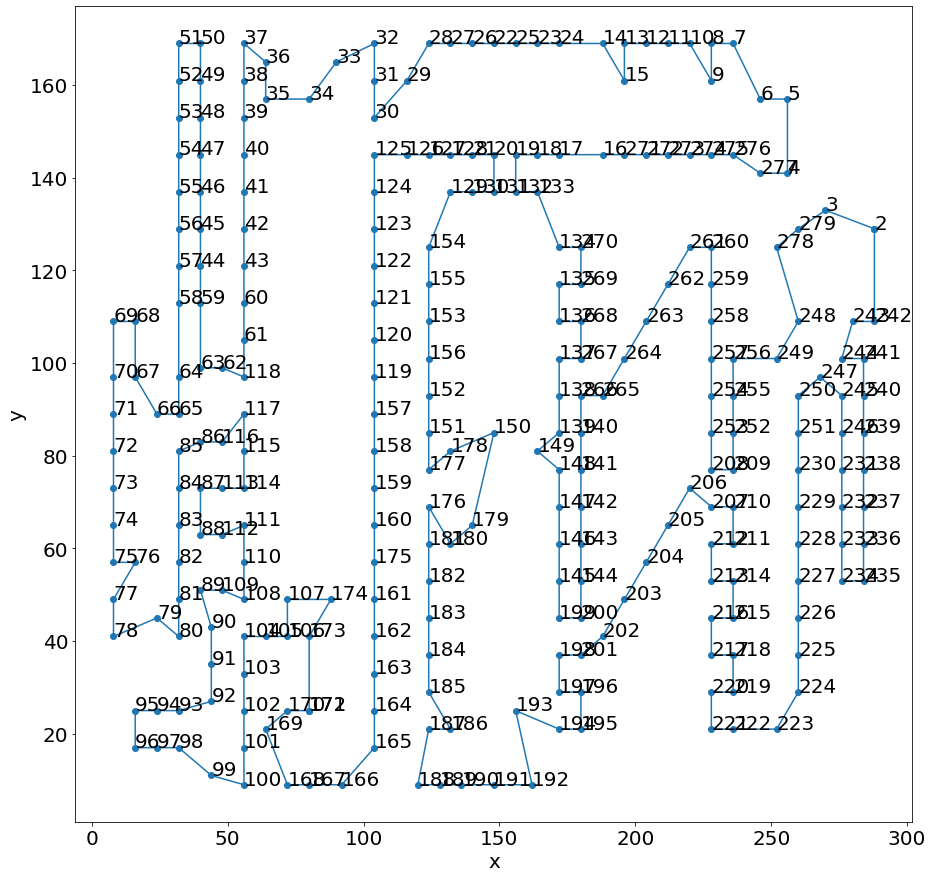

In [68]:
plot_path(coordinates_a280, opt_sol_a280)

Text(0, 0.5, 'mean route length')

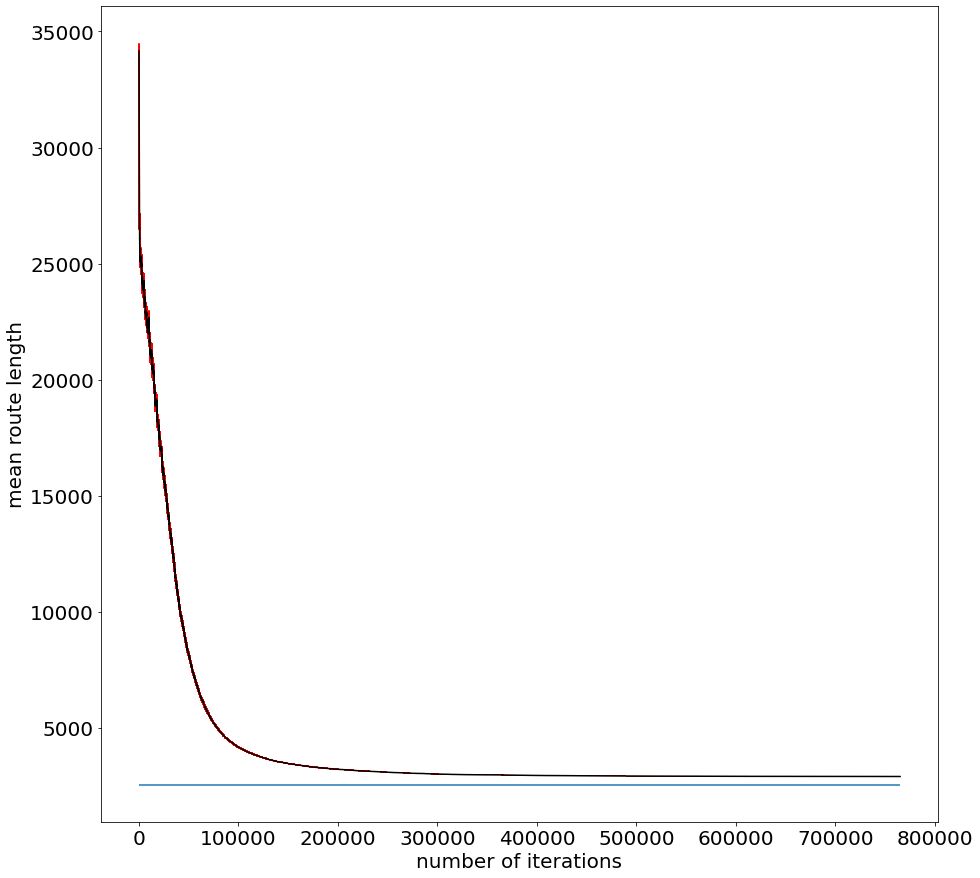

In [113]:
plt.errorbar(range(len(average_cost_per_mc_step_a280)), average_cost_per_mc_step_a280, yerr=ci_per_mc_step_a280, c='black', ecolor='red')
plt.hlines(opt_cost_a280, xmin=0, xmax=len(average_cost_per_mc_step_a280))
plt.xlabel('number of iterations')
plt.ylabel('mean route length')

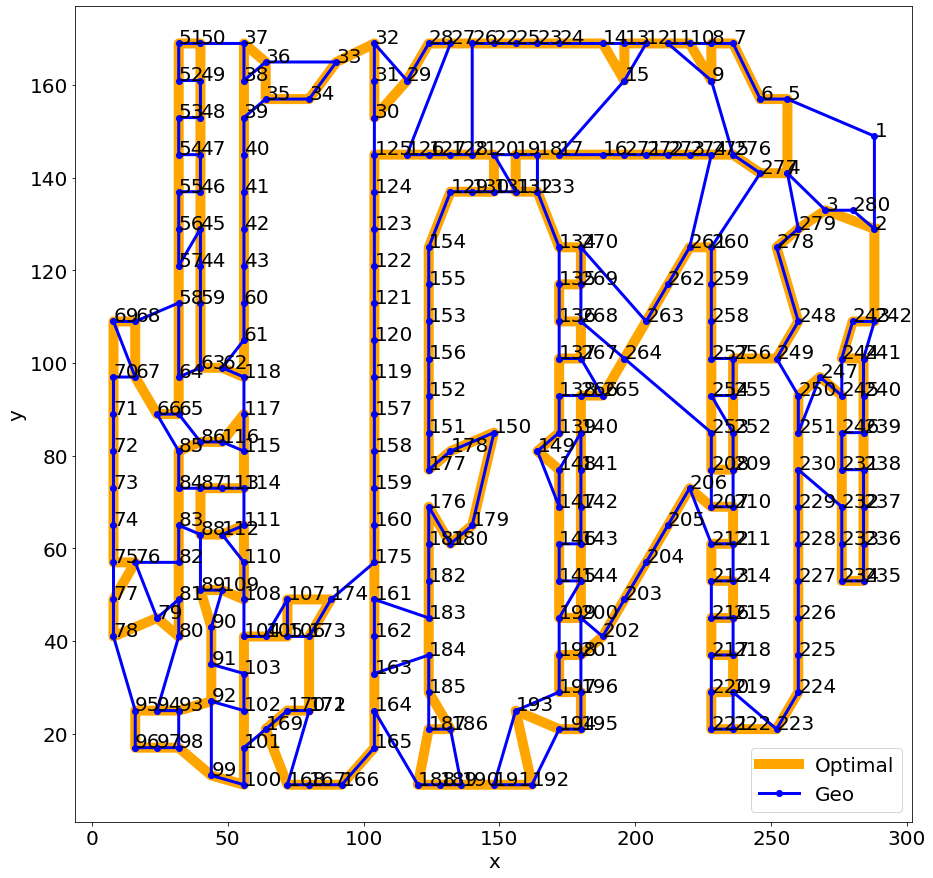

In [145]:
plot_path_overlay(coordinates_a280, routes_a280[-1], opt_path=opt_sol_a280)

# Testing how well 'Geo' cooling schedule, T0 = 100, and mc_length = 2,500 generalizes to other datasets

## EIL51

### Loading coordinates

In [77]:
df_eil51 = pd.read_csv('./eil51.tsp.txt', header=None, skiprows=6, skipfooter=1, sep=' ', engine='python', index_col=0)
# df.set_index(df[0])
print(df_eil51)

     1   2
0         
1   37  52
2   49  49
3   52  64
4   20  26
5   40  30
6   21  47
7   17  63
8   31  62
9   52  33
10  51  21
11  42  41
12  31  32
13   5  25
14  12  42
15  36  16
16  52  41
17  27  23
18  17  33
19  13  13
20  57  58
21  62  42
22  42  57
23  16  57
24   8  52
25   7  38
26  27  68
27  30  48
28  43  67
29  58  48
30  58  27
31  37  69
32  38  46
33  46  10
34  61  33
35  62  63
36  63  69
37  32  22
38  45  35
39  59  15
40   5   6
41  10  17
42  21  10
43   5  64
44  30  15
45  39  10
46  32  39
47  25  32
48  25  55
49  48  28
50  56  37
51  30  40


In [78]:
coordinates_eil51 = []
for index, row in df_eil51.iterrows():
    coordinates_eil51.append(Coordinate(index,row[1],row[2]))

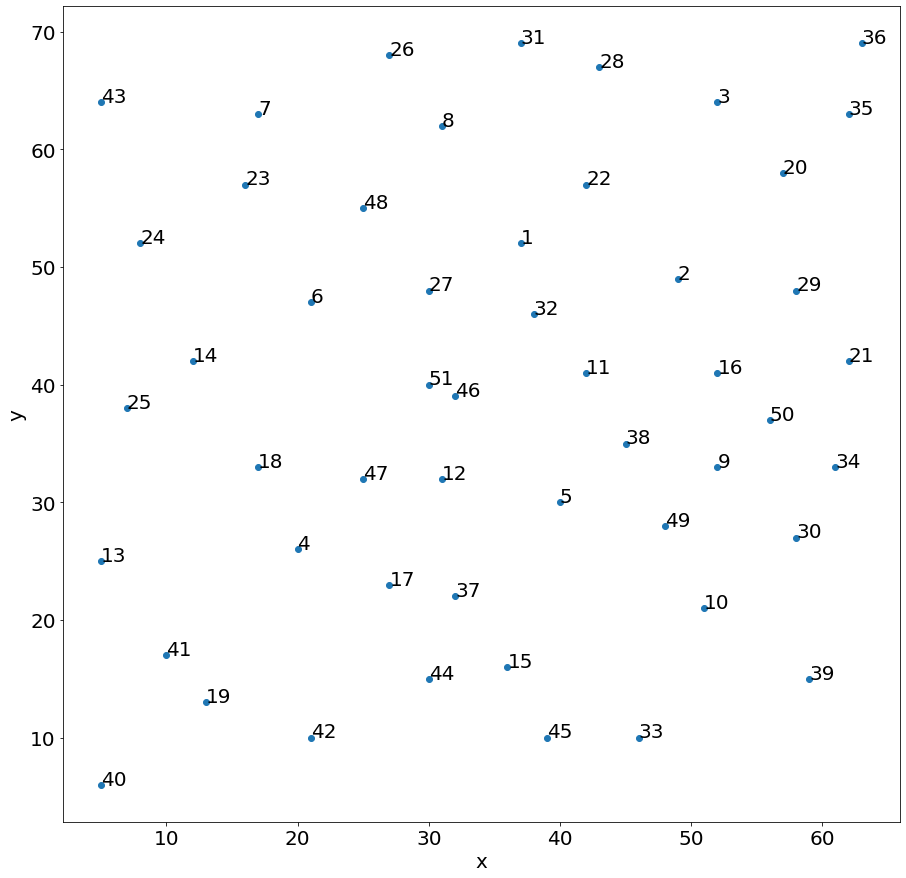

In [79]:
plot_coordinates(coordinates_eil51)

In [80]:
batch_routes_eil51 = []
batch_costs_eil51 = []
n_runs = 25

mc_length = 2500
T0 = 100

for i in range(n_runs):
    print(i)

    initial_solution_eil51 = generate_initial_sol(df_eil51)
    routes_eil51, costs_eil51, iters_eil51, temperatures_eil51 = sim_anneal(coordinates_eil51, initial_solution_eil51, T0=T0, mc_length=mc_length, cooling_schedule='geo')
    batch_routes_eil51.append(routes_eil51)
    batch_costs_eil51.append(costs_eil51)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [81]:
#Calculate all the averages and ci's for all mc steps
average_cost_per_mc_step_eil51 = []
ci_per_mc_step_eil51 = []
for i in range(len(batch_routes_eil51[0])):
    costs_temp_eil51 = []
    for k in batch_costs_eil51:
        costs_temp_eil51.append(k[i])
    average_cost_per_mc_step_eil51.append(np.mean(costs_temp_eil51))
    ci_per_mc_step_eil51.append(1.96*np.std(costs_temp_eil51)/np.sqrt(len(costs_temp_eil51))) 

Text(0, 0.5, 'mean route length')

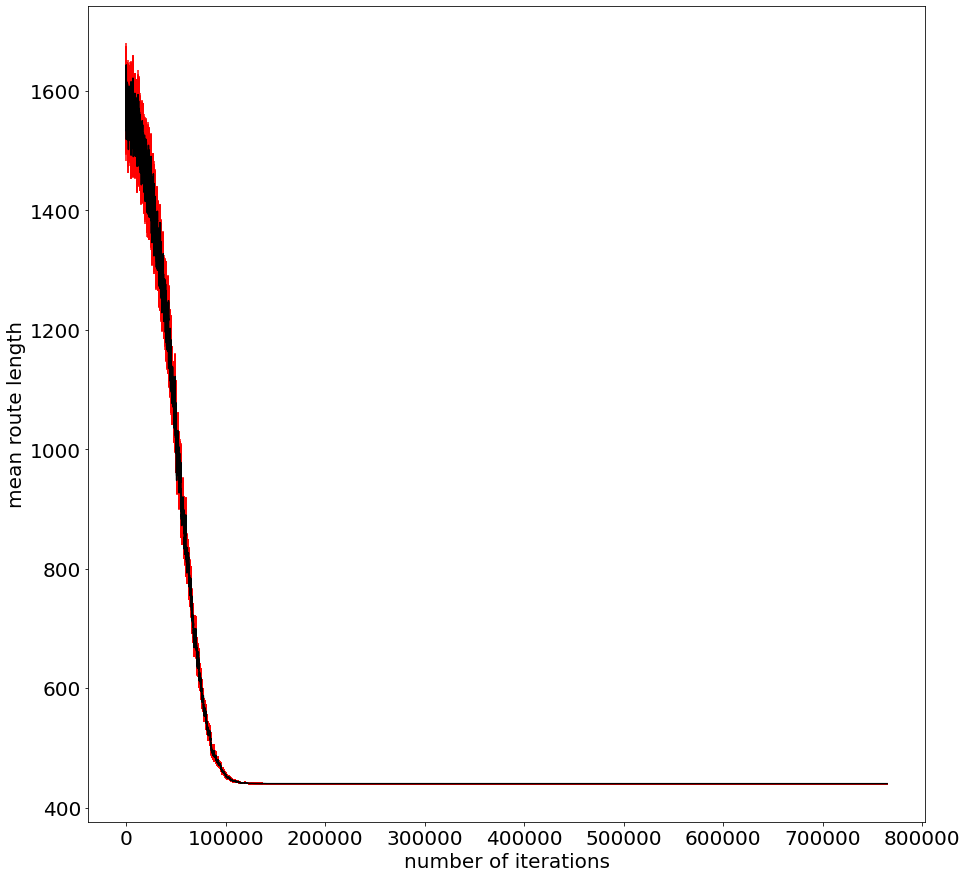

In [82]:
plt.errorbar(range(len(average_cost_per_mc_step_eil51)), average_cost_per_mc_step_eil51, yerr=ci_per_mc_step_eil51, c='black', ecolor='red')
plt.xlabel('number of iterations')
plt.ylabel('mean route length')

In [83]:
print(average_cost_per_mc_step_eil51[-1])

439.983924557458


In [84]:
print(ci_per_mc_step_eil51[-1])

1.7562137066238446


In [85]:
print(routes_eil51[-1])

[24, 43, 7, 23, 48, 8, 26, 31, 28, 22, 3, 36, 35, 20, 29, 21, 34, 30, 9, 50, 16, 2, 11, 38, 5, 49, 10, 39, 33, 45, 15, 37, 17, 44, 42, 19, 40, 41, 13, 18, 4, 47, 12, 46, 51, 32, 1, 27, 6, 14, 25]


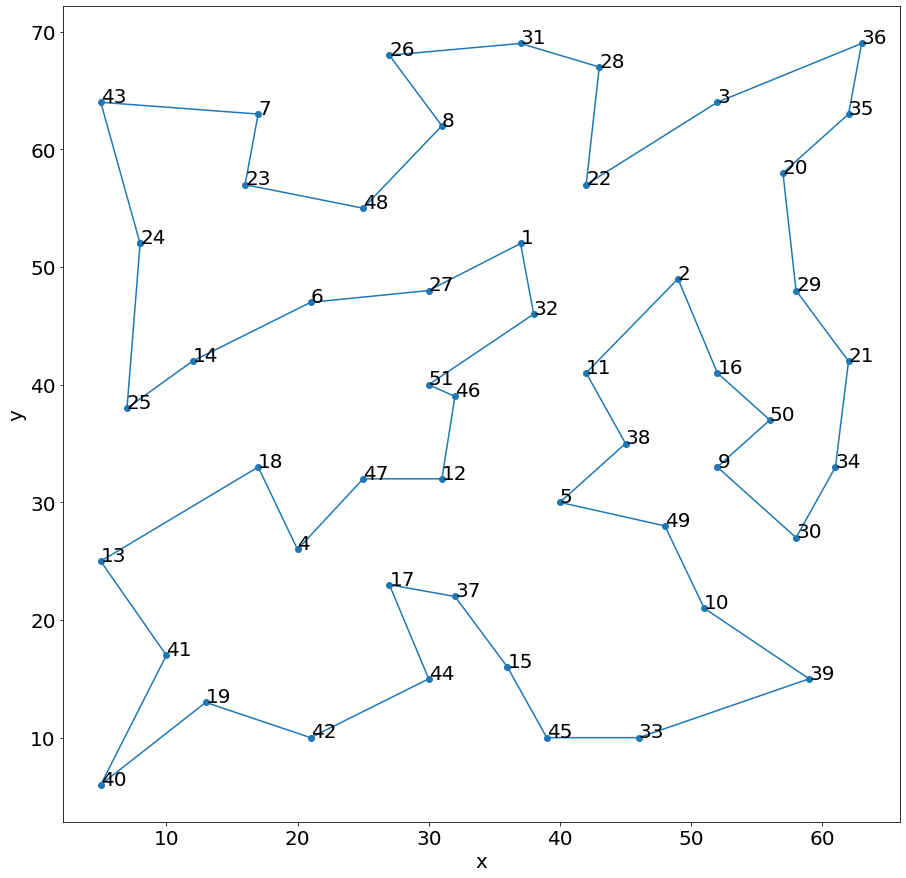

In [86]:
plot_path(coordinates_eil51, routes_eil51[-1])

### Compare to given optimal solution

In [87]:
opt_df = pd.read_csv('./eil51.opt.tour.txt', header=None, skiprows=5, skipfooter=1, sep=' ', engine='python')

In [88]:
opt_sol = opt_df.iloc[:,0].values[:-1]
#append 1 on end iinstead of -1
#opt_sol[-1] = 1
print(opt_sol)

[ 1 22  8 26 31 28  3 36 35 20  2 29 21 16 50 34 30  9 49 10 39 33 45 15
 44 42 40 19 41 13 25 14 24 43  7 23 48  6 27 51 46 12 47 18  4 17 37  5
 38 11 32]


In [115]:
opt_cost_eil51 = get_total_cost(coordinates_eil51, opt_sol)
print(opt_cost_eil51)

429.98331198338406


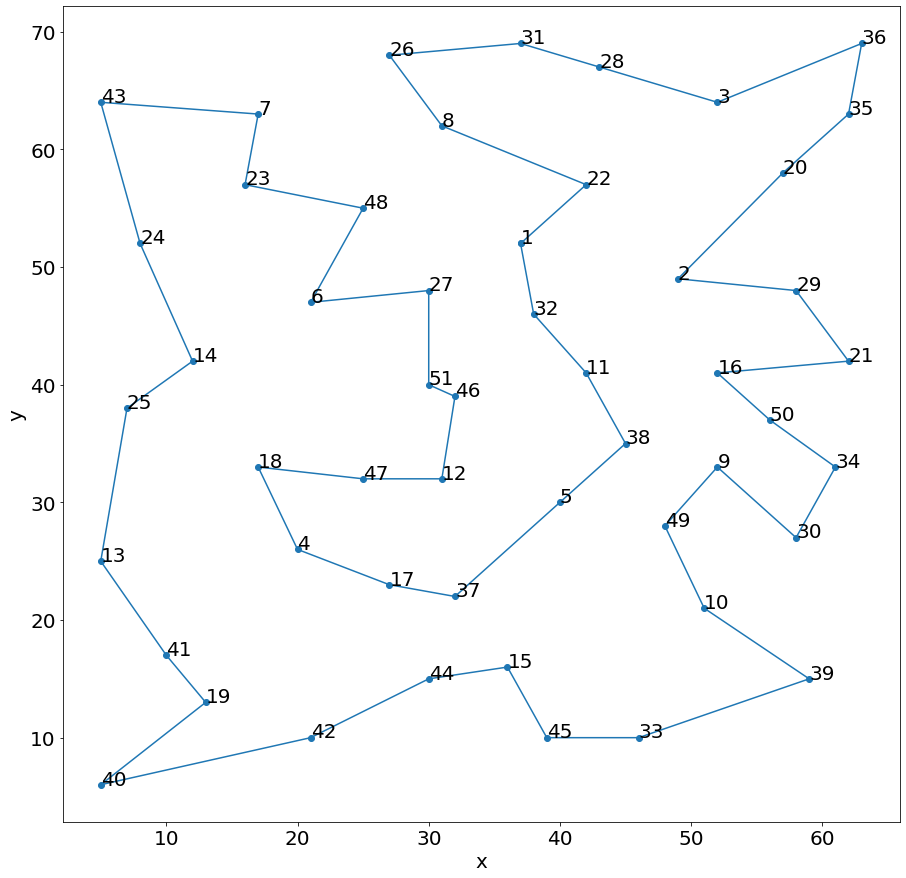

In [125]:
plot_path(coordinates_eil51, opt_sol)

Text(0, 0.5, 'mean route length')

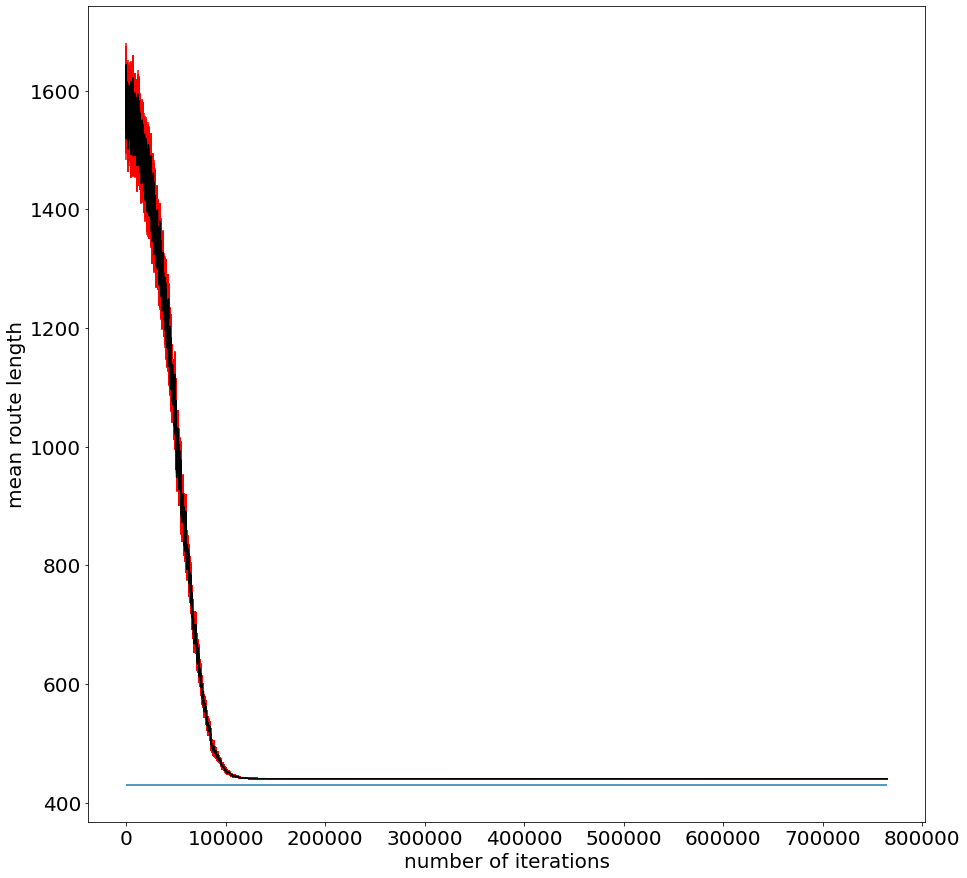

In [116]:
plt.errorbar(range(len(average_cost_per_mc_step_eil51)), average_cost_per_mc_step_eil51, yerr=ci_per_mc_step_eil51, c='black', ecolor='red')
plt.hlines(opt_cost_eil51, xmin=0, xmax=len(average_cost_per_mc_step_eil51))
plt.xlabel('number of iterations')
plt.ylabel('mean route length')

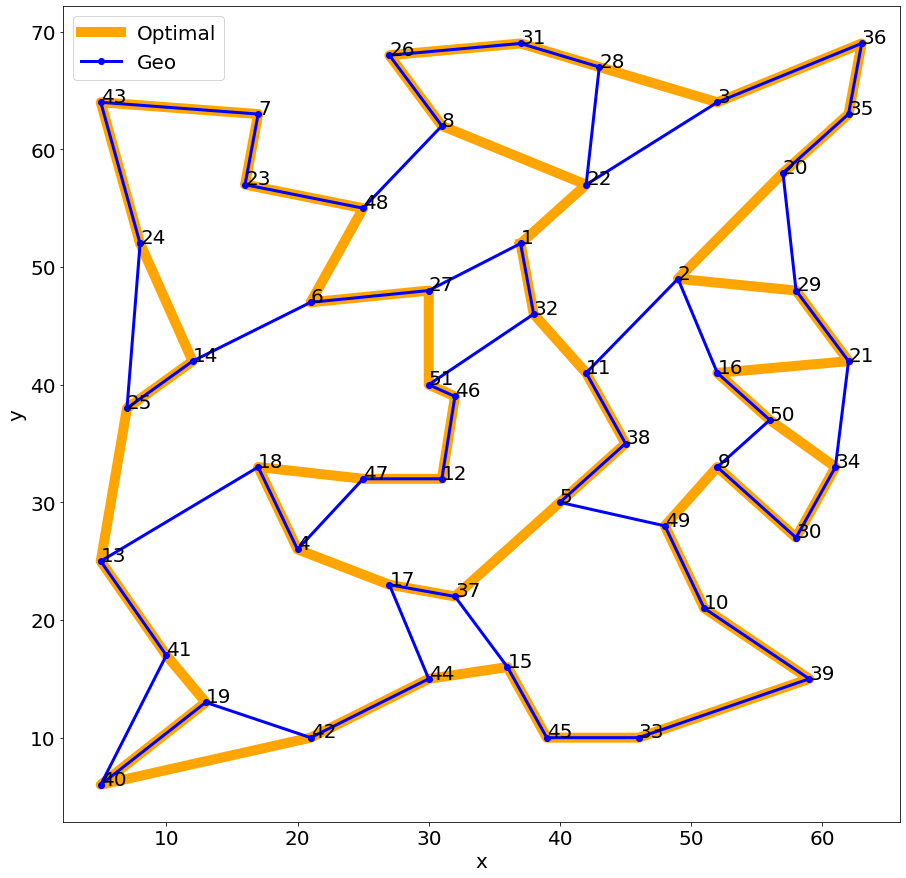

In [146]:
plot_path_overlay(coordinates_eil51, routes_eil51[-1], opt_path=opt_sol)

## PCB442

### Loading coordinates

In [91]:
df_pcb442 = pd.read_csv('./pcb442.tsp.txt', header=None, skiprows=6, skipfooter=1, sep=' ', engine='python', index_col=0)
# df.set_index(df[0])
print(df_pcb442)

          1       2
0                  
1     200.0   400.0
2     200.0   500.0
3     200.0   600.0
4     200.0   700.0
5     200.0   800.0
..      ...     ...
438  2320.0  3150.0
439   530.0  2100.0
440  2550.0   710.0
441   750.0   490.0
442     0.0     0.0

[442 rows x 2 columns]


In [92]:
coordinates_pcb442 = []
for index, row in df_pcb442.iterrows():
    coordinates_pcb442.append(Coordinate(index,row[1],row[2]))

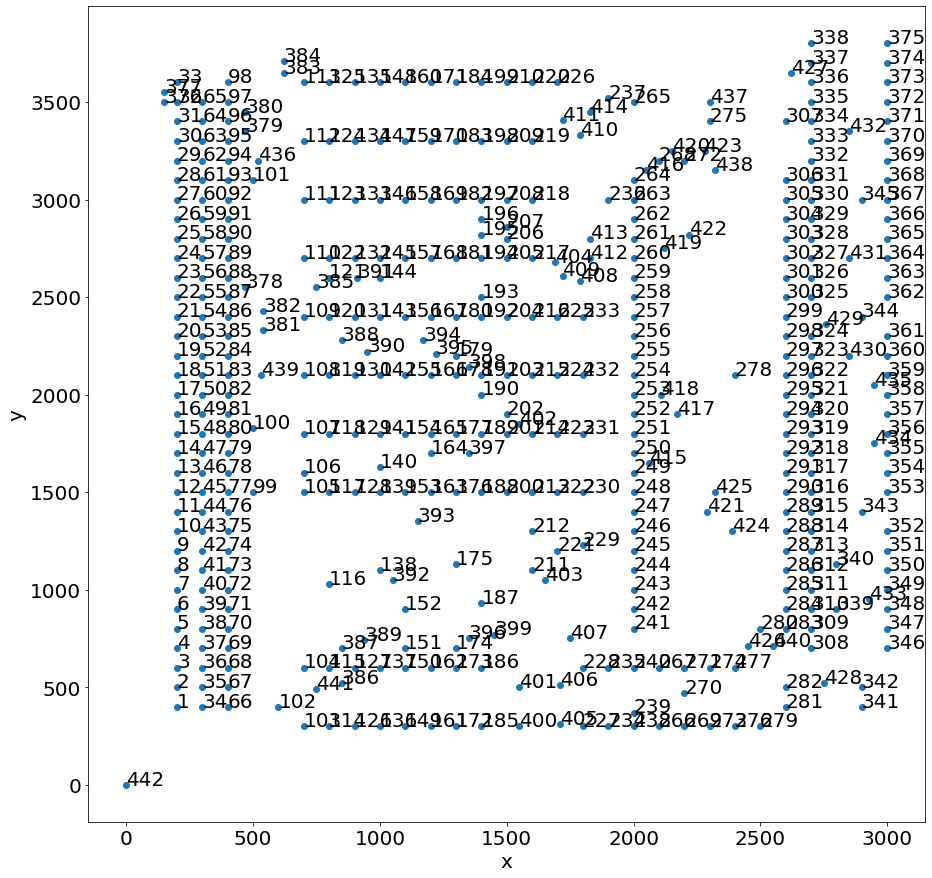

In [93]:
plot_coordinates(coordinates_pcb442)

In [94]:
batch_routes_pcb442 = []
batch_costs_pcb442 = []
n_runs = 25

mc_length = 2500
T0 = 100

for i in range(n_runs):
    print(i)

    initial_solution_pcb442 = generate_initial_sol(df_pcb442)
    routes_pcb442, costs_pcb442, iters_pcb442, temperatures_pcb442 = sim_anneal(coordinates_pcb442, initial_solution_pcb442, T0=T0, mc_length=mc_length, cooling_schedule='geo')
    batch_routes_pcb442.append(routes_pcb442)
    batch_costs_pcb442.append(costs_pcb442)

0


<ipython-input-13-59b058093738>:2: RuntimeWarning: overflow encountered in exp
  a = min(np.exp(-(new_cost - old_cost) / T), 1)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [95]:
#Calculate all the averages and ci's for all mc steps
average_cost_per_mc_step_pcb442 = []
ci_per_mc_step_pcb442 = []
for i in range(len(batch_routes_pcb442[0])):
    costs_temp_pcb442 = []
    for k in batch_costs_pcb442:
        costs_temp_pcb442.append(k[i])
    average_cost_per_mc_step_pcb442.append(np.mean(costs_temp_pcb442))
    ci_per_mc_step_pcb442.append(1.96*np.std(costs_temp_pcb442)/np.sqrt(len(costs_temp_pcb442))) 

Text(0, 0.5, 'mean route length')

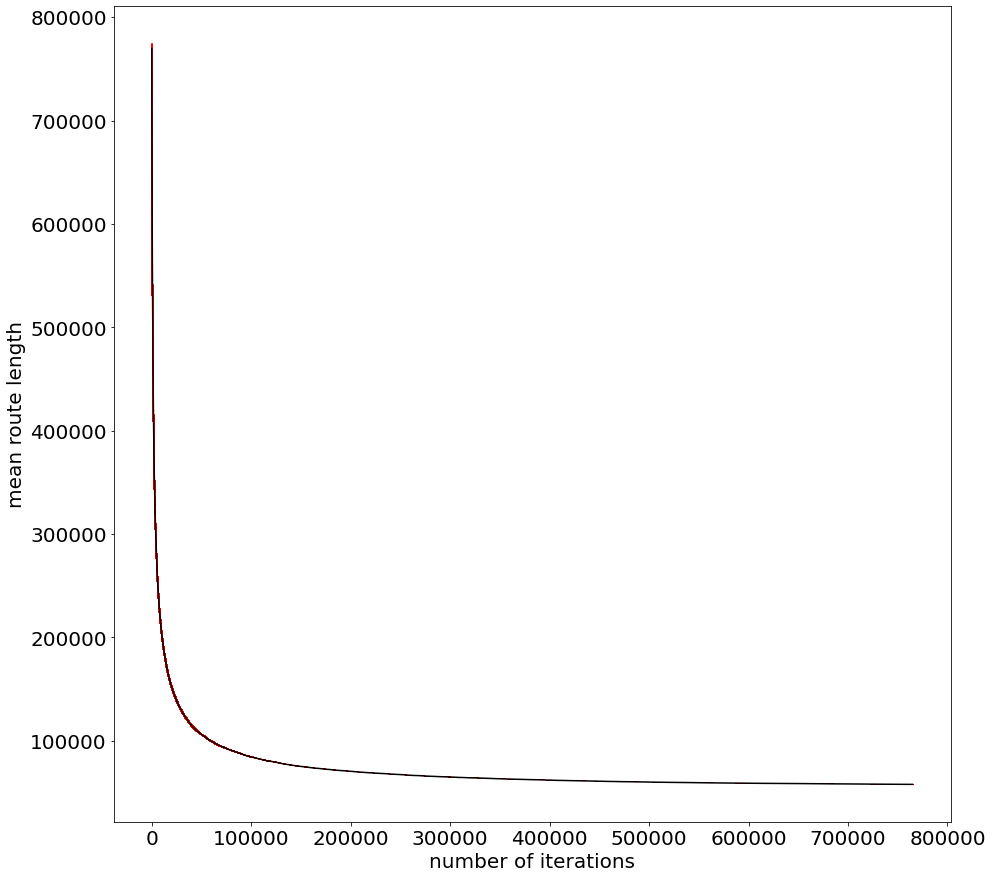

In [96]:
plt.errorbar(range(len(average_cost_per_mc_step_pcb442)), average_cost_per_mc_step_pcb442, yerr=ci_per_mc_step_pcb442, c='black', ecolor='red')
plt.xlabel('number of iterations')
plt.ylabel('mean route length')

In [97]:
print(average_cost_per_mc_step_pcb442[-1])

57829.96140509667


In [98]:
print(ci_per_mc_step_pcb442[-1])

354.01200504664496


In [99]:
print(routes_pcb442[-1])

[99, 106, 107, 118, 129, 130, 119, 108, 381, 109, 120, 131, 388, 390, 142, 141, 154, 164, 165, 177, 189, 397, 163, 176, 188, 200, 213, 222, 212, 229, 246, 245, 244, 243, 242, 241, 267, 240, 235, 228, 407, 403, 221, 211, 187, 399, 396, 174, 173, 162, 150, 151, 389, 387, 137, 127, 386, 441, 115, 104, 102, 103, 114, 126, 136, 149, 161, 172, 185, 400, 186, 401, 406, 405, 227, 234, 239, 238, 266, 269, 273, 276, 270, 271, 274, 277, 426, 440, 280, 284, 310, 283, 309, 308, 282, 279, 281, 428, 341, 342, 346, 347, 348, 433, 339, 311, 285, 312, 286, 287, 288, 424, 421, 425, 247, 248, 249, 230, 231, 250, 415, 251, 252, 232, 224, 223, 214, 402, 201, 202, 190, 215, 203, 191, 398, 179, 178, 166, 155, 395, 394, 167, 156, 143, 144, 145, 391, 132, 122, 121, 385, 110, 89, 58, 90, 91, 92, 101, 436, 111, 123, 133, 112, 124, 134, 147, 159, 170, 183, 198, 209, 219, 411, 410, 218, 208, 207, 195, 196, 197, 182, 169, 158, 146, 157, 168, 181, 194, 205, 206, 217, 193, 180, 192, 204, 216, 225, 233, 408, 409, 404, 

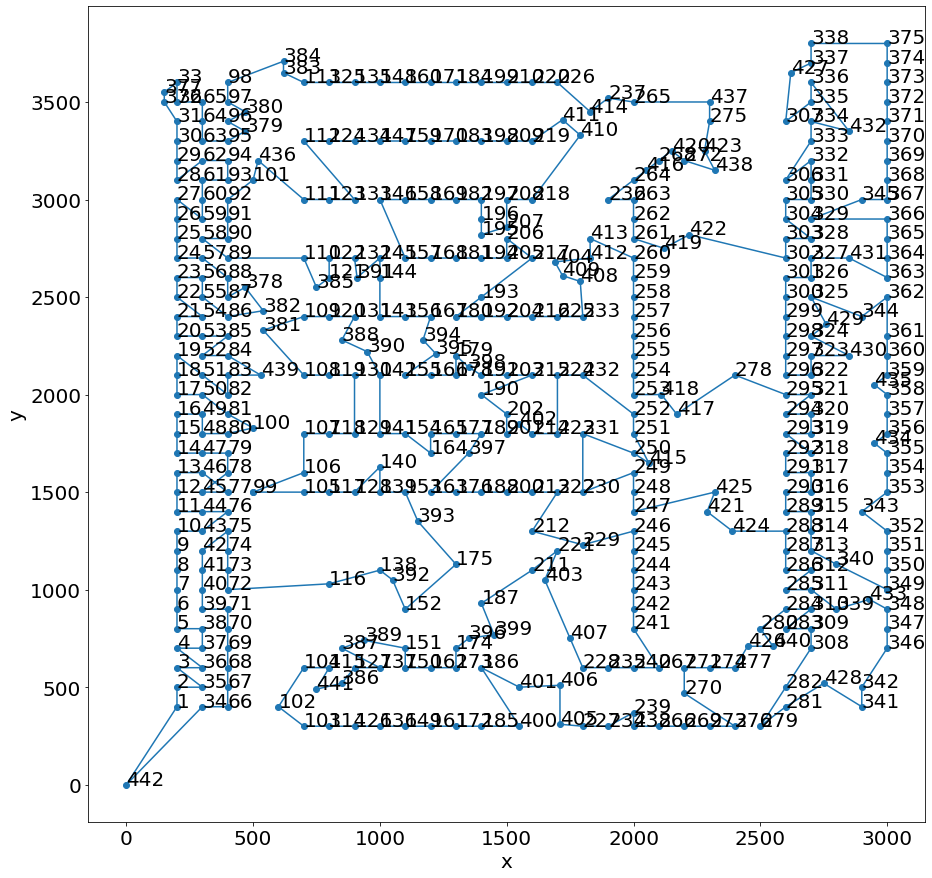

In [100]:
plot_path(coordinates_pcb442, routes_pcb442[-1])

### Compare to given optimal solution

In [101]:
opt_df_pcb442 = pd.read_csv('./pcb442.opt.tour.txt', header=None, skiprows=5, skipfooter=1, sep=' ', engine='python')

In [102]:
opt_sol_pcb442 = opt_df_pcb442.iloc[:,0].values[:-1]
#append 1 on end iinstead of -1
#opt_sol[-1] = 1
print(opt_sol_pcb442)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  53  52  51  83  84  85 381 382  86  54  21  22  55  87 378  88
  56  23  24  25  26  27  28  29  30  31  32 376 377  33  65  64  63  62
  61  60  59  58  57  89  90  91  92  93 101 111 123 133 146 158 169 182
 197 196 195 194 181 168 157 145 144 391 132 122 110 121 385 109 120 388
 131 143 156 167 180 193 192 204 216 225 233 408 409 412 413 404 217 205
 206 207 208 218 219 209 198 183 170 159 147 134 124 112 436  94  95 379
  96 380  97  98 384 383 113 125 135 148 160 171 184 199 210 220 226 411
 410 414 237 265 437 275 423 438 272 420 268 416 264 236 263 262 261 422
 419 260 259 258 257 256 255 254 253 418 417 252 251 250 415 249 248 247
 246 245 244 243 242 241 407 228 235 240 267 271 270 274 277 426 280 440
 308 309 283 284 310 339 311 285 286 312 340 313 287 288 314 315 316 290
 289 424 421 425 291 317 318 292 293 319 320 294 295 321 322 296 278 297
 323 430 429 324 298 299 300 325 326 301 302 327 32

In [103]:
opt_cost_pcb442 = get_total_cost(coordinates_pcb442, opt_sol_pcb442)
print(opt_cost_pcb442)

50783.54751373533


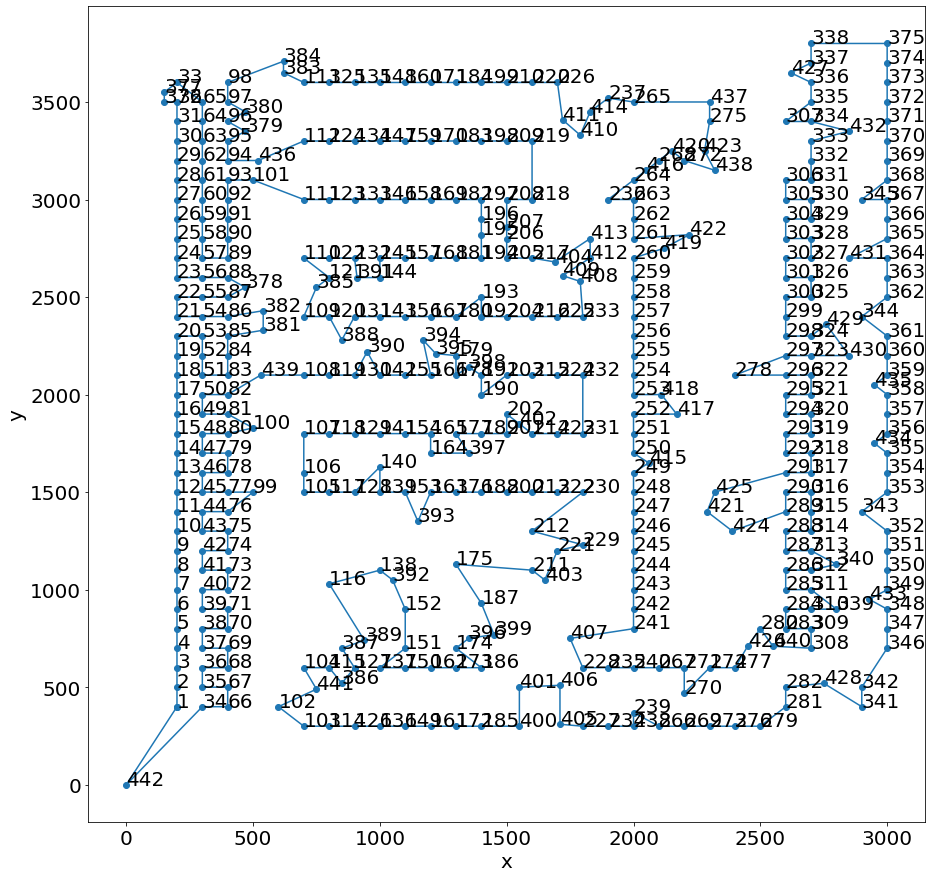

In [104]:
plot_path(coordinates_pcb442, opt_sol_pcb442)

Text(0, 0.5, 'mean route length')

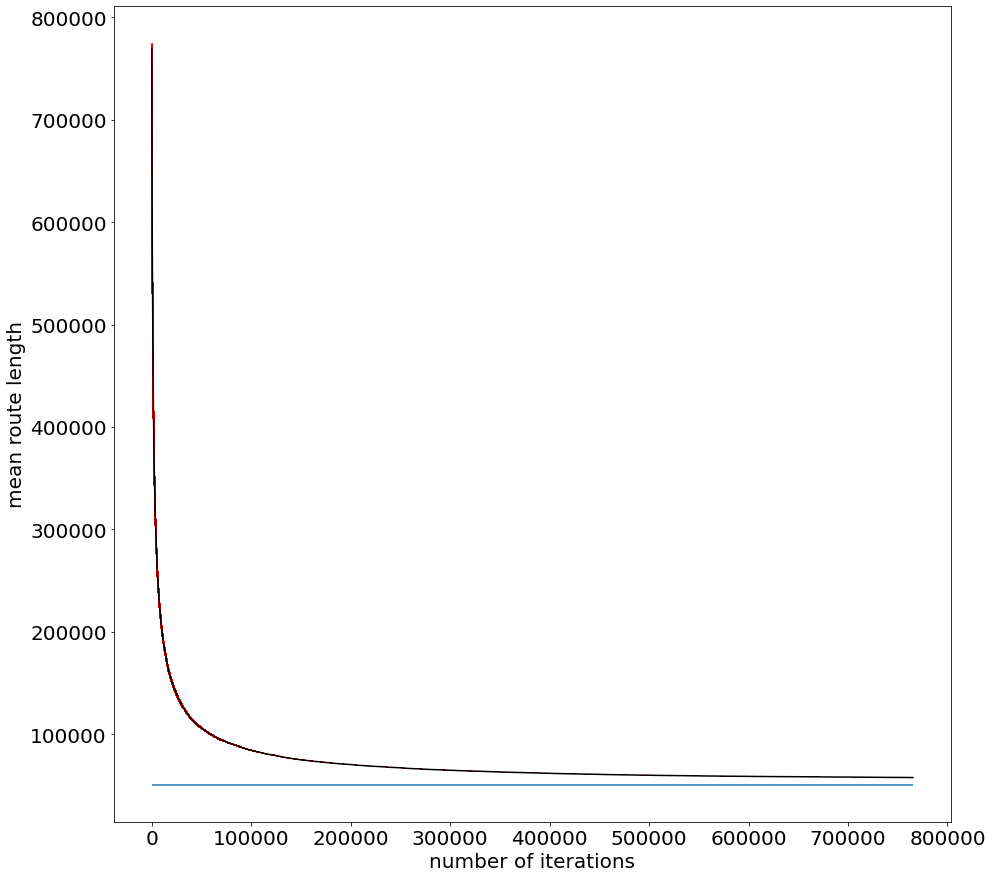

In [118]:
plt.errorbar(range(len(average_cost_per_mc_step_pcb442)), average_cost_per_mc_step_pcb442, yerr=ci_per_mc_step_pcb442, c='black', ecolor='red')
plt.hlines(opt_cost_pcb442, xmin=0, xmax=len(average_cost_per_mc_step_pcb442))
plt.xlabel('number of iterations')
plt.ylabel('mean route length')

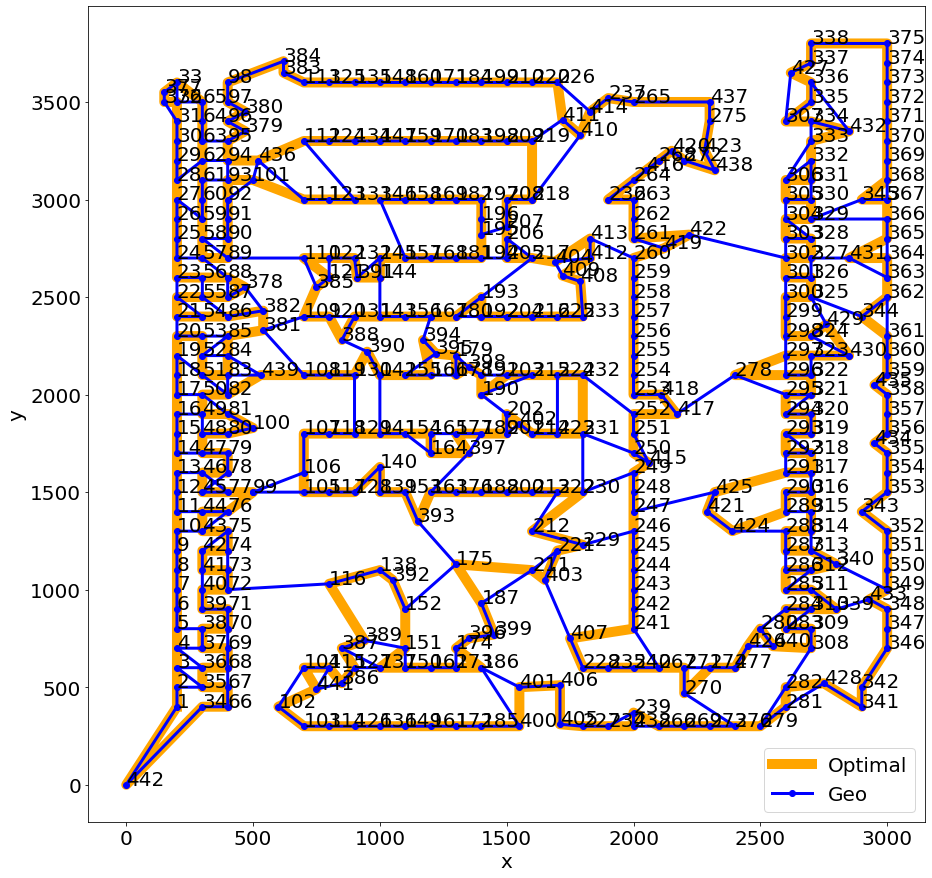

In [147]:
plot_path_overlay(coordinates_pcb442, routes_pcb442[-1], opt_path=opt_sol_pcb442)